In [1]:
import sys
import numpy as np
from scipy.stats import gaussian_kde
import theano.tensor as T
import theano
import os
import re
import glob
import h5py
from scipy.stats import norm
from keras import *
from sklearn.metrics import roc_curve, roc_auc_score, auc
from keras.models import Sequential,Model
from keras.layers import Dense, Activation,Input, Dense, Dropout, merge, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import *
from keras.models import model_from_json, save_model
from keras.layers import *
import matplotlib.pyplot as pt
%matplotlib inline
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_QRu4vG.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda0: GeForce GTX 860M (0000:01:00.0)
Using Theano backend.


In [2]:
def loadmodel(name, weights = False):
    json_file = open('/home/kaustuv1993/Desktop/H2bb/Models_and_Weights/%s_m.json'%name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    #load weights into new model
    if weights==True:
        model.load_weights('/home/kaustuv1993/Desktop/H2bb/Models_and_Weights/%s_w.h5'%name)
    print (model.summary())
    print("Loaded model %s from disk"%name)
    return model

def savemodel(model,name="neural network"):
    #print "Saving model:"
    model_name = name
    #model.summary()
    model.save_weights('/home/kaustuv1993/Desktop/H2bb/Models_and_Weights/%s_w.h5'%model_name, overwrite=True)
    model_json = model.to_json()
    with open("/home/kaustuv1993/Desktop/H2bb/Models_and_Weights/%s_m.json"%model_name, "w") as json_file:
        json_file.write(model_json)
        
def savelosses(hist, name="neural network"):  
    print "Saving losses:"
    loss = np.array(hist.history['loss'])
    valoss = np.array(hist.history['val_loss'])
    f = h5py.File("/home/kaustuv1993/Desktop/H2bb/Models_and_Weights/%s_h.h5"%name,"w")
    f.create_dataset('loss',data=loss)
    f.create_dataset('val_loss',data=valoss)
    f.close()

In [3]:
#import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

def get_cmap(N):
    
    '''Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.'''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

In [4]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers.advanced_activations import PReLU, LeakyReLU

In [5]:
def hist(y, n=25):
    plt.figure(figsize=(8,8))
    l = y.min()
    r = y.max()
    w = ((r-l)/float(y.shape[0]*1.))
    plt.hist(y, histtype='step', bins=n)
    plt.show()

#generates a Gaussian 
def gaussian(batch_size, mu=0.,sigma=0.5):
    sample = np.random.normal(mu, sigma, batch_size)
    sample.sort()
    return np.reshape(sample,(len(sample),1))

def noise(batch_size, m=-2.5, M=2.5):
    a = np.linspace(m, M, batch_size) + np.random.random(batch_size) * 0.01
    return np.reshape(a,(len(a),1))

def noise_g(batch_size, mu=0.,sigma=1.0):
    sample = np.random.normal(mu, sigma, batch_size)+np.random.random(batch_size) * 0.01
    sample.sort()
    return np.reshape(sample,(len(sample),1))

#y=gaussian(batch_size=10000, mu=5, sigma=5)
#print y.shape
#hist(y)

(array([   5.,   17.,   66.,  150.,  235.,  260.,  179.,   66.,   19.,    3.]),
 array([-3.69974842, -3.36743342, -3.03511842, -2.70280343, -2.37048843,
        -2.03817343, -1.70585843, -1.37354344, -1.04122844, -0.70891344,
        -0.37659845]),
 <a list of 10 Patch objects>)

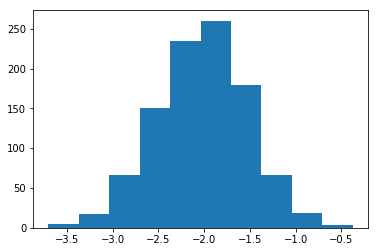

In [6]:
plt.hist(noise_g(1000, -2 , 0.5))

In [9]:
def plot_loss(losses,modelname="GAN"):
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    plt.figure(figsize=(16,9))
    plt.plot(losses["d_f"], label='discriminative loss on fake', alpha=0.8)
    plt.plot(losses["d_t"], label='discriminative loss on true', alpha=0.8)
    plt.plot(losses["d"], label = 'discriminative loss', alpha=0.8)
    plt.plot(losses["g"], label='generative loss', alpha=0.8)
    #plt.yscale('log')
    plt.xlabel('Epochs', fontsize=22)
    plt.ylabel('Loss', fontsize=22)
    plt.legend(fontsize=22, loc='best', fancybox=True, framealpha=0.)
    plt.savefig("%s_loss.png"%modelname)
    plt.show()


In [10]:
opt = Adam(lr=1e-4)#, decay = 0.009)
dopt = Adam(lr=1e-3)#, decay = 0.0009)
from keras.models import Sequential,Model
from keras.layers import concatenate, merge
def gen_f():
    
    g_input= Input(shape=[1])
    mean_input = Input(shape=[1])
    g = merge([g_input, mean_input])
    g = Dense(200)(g)
    g = LeakyReLU()(g)
    g = Dense(200)(g)
    g = LeakyReLU()(g)
    g = Dense(1, activation='linear')(g)
    G = Model(inputs=[g_input, mean_input], outputs=[g] )
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G

#def disc_f():

#    d_input= Input(shape=[1])
#    d = Dense(400)(d_input)
#    d = Activation('tanh')(d)
#    d = BatchNormalization()(d)
#    d = Dense(400)(d)
#    d = Activation('tanh')(d)
    #d = Dense(400)(d)
    #d = Activation('tanh')(d)
    #d = Flatten()(d)
#    d = MinibatchDiscrimination(nb_kernels=10, kernel_dim=1)(d)#, input_shape=(None, 400),)(d)
    #minibatch_featurizer = Lambda(minibatch_discriminator,
                                     # output_shape=minibatch_output_shape)
    #features = [d]
    
    #nb_features = 10
    #vspace_dim = 2

    # creates the kernel space for the minibatch discrimination
    #K_x = Dense3D(nb_features, vspace_dim)(x)
    #features.append(Activation('tanh')(minibatch_featurizer(K_x)))
    
    
    
#    d = Dense(1, kernel_initializer='normal', activation='sigmoid')(d)
#    D = Model(d_input,d)
#    D.compile(loss='binary_crossentropy', optimizer=dopt)
#    return D


In [11]:
##From CaloGAN paper
from ops_CaloGAN import *
def minibatch_discriminator(x):
    """ Computes minibatch discrimination features from input tensor x"""
    diffs = K.expand_dims(x, 3) - K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
    l1_norm = K.sum(K.abs(diffs), axis=2)
    return K.sum(K.exp(-l1_norm), axis=2)


def minibatch_output_shape(input_shape):
    """ Computes output shape for a minibatch discrimination layer"""
    shape = list(input_shape)
    assert len(shape) == 3  # only valid for 3D tensors
    return tuple(shape[:2])




def build_discriminator(d_input, mbd=False):
    """ Generator sub-component for the CaloGAN ---- reusing this recipe for now (KD)

    Args:
    -----
        mdb: bool, perform feature level minibatch discrimination
        
    Returns:
    --------
        a keras tensor of features

    """
    d_input= Input(shape=[1])
    mean_input = Input(shape=[1])
    d = merge([d_input, mean_input])
    d = Dense(400)(d)
    d = Activation('tanh')(d)
    d = Dropout(0.2)(d)
    d = Dense(400)(d)
    d = Activation('tanh')(d)
    d = Dropout(0.2)(d)
    d = Dense(400)(d)
    d = Activation('tanh')(d)
    d = Dropout(0.2)(d)
    #d = Dense(400)(d)
    #d = Activation('tanh')(d)
    #d = Dropout(0.2)(d)
    #d = BatchNormalization()(d)
    if mbd:
        minibatch_featurizer = Lambda(minibatch_discriminator,
                                      output_shape=minibatch_output_shape)

        features = [d]
        nb_features = 5
        vspace_dim = 3

        # creates the kernel space for the minibatch discrimination
        K_d = Dense3D(nb_features, vspace_dim)(d)
        features.append(Activation('tanh')(minibatch_featurizer(K_d)))
        features = concatenate(features)
        #p = concatenate([features])
        D = Dense(1, kernel_initializer='normal', activation='sigmoid')(features)
        discriminator = Model(inputs=[d_input, mean_input], outputs=[D])
        discriminator.compile(loss='binary_crossentropy', optimizer=dopt)
        return discriminator
    
    else:
        d = Dense(400)(d)
        d = Activation('tanh')(d)
        d = Dense(1, kernel_initializer='normal', activation='sigmoid')(d)
        discriminator = Model(inputs=[d_input, mean_input], outputs=[d])
        discriminator.compile(loss='binary_crossentropy', optimizer=dopt)
        return discriminator

In [12]:
from keras.models import Sequential,Model
from keras.layers import add, concatenate, multiply
mbd=True
def GAN_f(generator, discriminator):

    noise=Input(shape=[1])
    mean = Input(shape=[1])
    generator_inputs = [noise,mean]
    g=generator((generator_inputs))
    disc_inputs = [g, mean]
    d=discriminator((disc_inputs))
    discriminator.trainable = False
    
    GAN = Model(generator_inputs, d)
    GAN.compile(loss='binary_crossentropy', optimizer=opt)
    #GAN.summary()
    return GAN


D = build_discriminator(d_input=Input(shape=[1]), mbd=True)
D.summary()
G = gen_f()
G.summary()
Model = GAN_f(G, D)
D.trainable = True
Model.summary()
#p_g = G.predict(noise(10000))
#plt.hist(p_g)
#plt.show()
#p_d = D.predict(np.ones(5000))
#p_d = np.concatenate((p_d, D.predict(np.zeros(5000))))
#plt.hist(p_d)

/home/kaustuv1993/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
merge_2 (Merge)                  (None, 1)             0           input_5[0][0]                    
                                                                   input_6[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 400)           800         merge_2[0][0]           

/home/kaustuv1993/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':


dense_9 (Dense)                  (None, 200)           400         merge_3[0][0]                    
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 200)           0           dense_9[0][0]                    
____________________________________________________________________________________________________
dense_10 (Dense)                 (None, 200)           40200       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)        (None, 200)           0           dense_10[0][0]                   
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 1)             201         leaky_re_lu_2[0][0]              
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_____________________

In [13]:
def plot_decision_boundary(disc,mean):
    plt.figure(figsize=(16,9))
    xs = np.linspace(-2.5, 2.5, 10000)
    plt.plot(xs, norm.pdf(xs, loc=0, scale=0.5), label='true_dist')
    r = 10000
    xs = np.float32(np.linspace(-2.5, 2.5, r))
    mean_col = mean*np.ones((r,1))
    ds_tensor = disc.predict([xs,mean_col])
    plt.plot(xs, ds_tensor, label='disc. decision boundary, mean=%f'%mean_col[0])
    plt.legend(fontsize=22, loc='best', fancybox=True, framealpha=0.)
    plt.show()

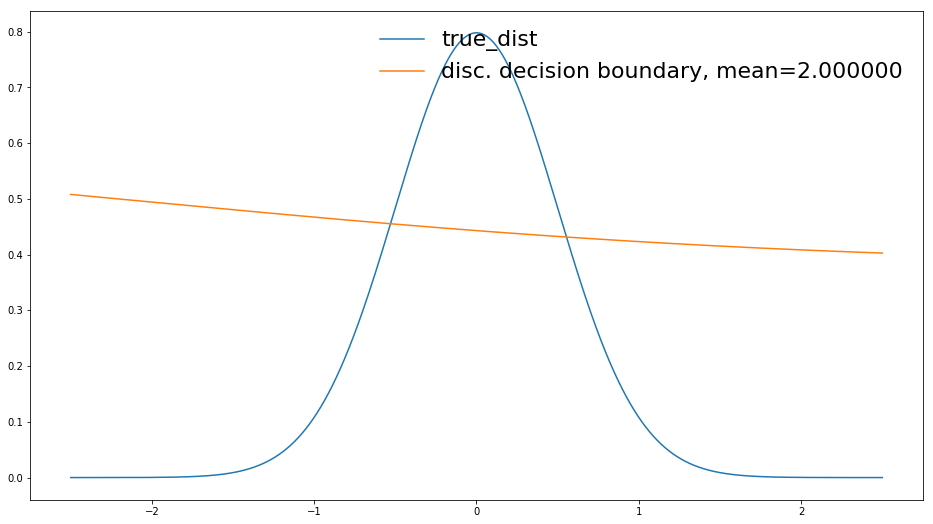

In [14]:
batch_size = 2000
import random
losses = {"d_f":[], "d_t":[], "d":[], "g":[]}
def train(G, D, M, epoch, mean):
    
    true_disc_x = gaussian(batch_size,mu=mean,sigma=0.5)
    sd = np.std(true_disc_x)
    #mean = np.mean(true_disc_x)
    mean_col = mean*np.ones((batch_size,1))
    latent = noise_g(batch_size, mu=0., sigma=10.)*mean_col #noise_g(batch_size, mu=0., sigma = 1.)  # m=true_disc_x.min(), M=true_disc_x.max())
    true_disc_y = np.zeros(batch_size)
    fake_disc_x = G.predict([latent, mean_col])
    #one-sided label smoothing: random.uniform(0.8,1.0)*
    fake_disc_y = np.ones(batch_size)
    
    #x_disc = np.concatenate((true_disc_x, fake_disc_x))
    #x_disc = x_disc.reshape((x_disc.shape[0], 1))
    #y_disc = np.concatenate((true_disc_y, fake_disc_y))
    #y_disc = y_disc.reshape((y_disc.shape[0], 1))
    
    G.trainable = False
    D.trainable = True
    d_loss_true = D.train_on_batch([true_disc_x, mean_col], true_disc_y)
    d_loss_fake = D.train_on_batch([fake_disc_x, fake_disc_x.mean()*np.ones((batch_size,1))], fake_disc_y)
    d_loss = (d_loss_true + d_loss_fake) / 2.0
    losses["d_f"].append(d_loss_fake)
    losses["d_t"].append(d_loss_true)
    losses["d"].append(d_loss)
    
    x_gen_1 = latent
    x_gen_2 = mean_col
    y_gen = np.zeros(batch_size)    
       
    G.trainable = True 
    D.trainable = False    
    
    GAN_loss = M.train_on_batch([x_gen_1, x_gen_2] , y_gen)
    losses["g"].append(GAN_loss)
    
    return d_loss, GAN_loss

plot_decision_boundary(D,2)


Epoch 1, Discriminator loss:1.02561080456, GAN loss:0.567714452744
For true: mean and s.d. =  -1.99595322291 0.49540058727
For generator: mean and s.d. =  -0.184859 3.50628


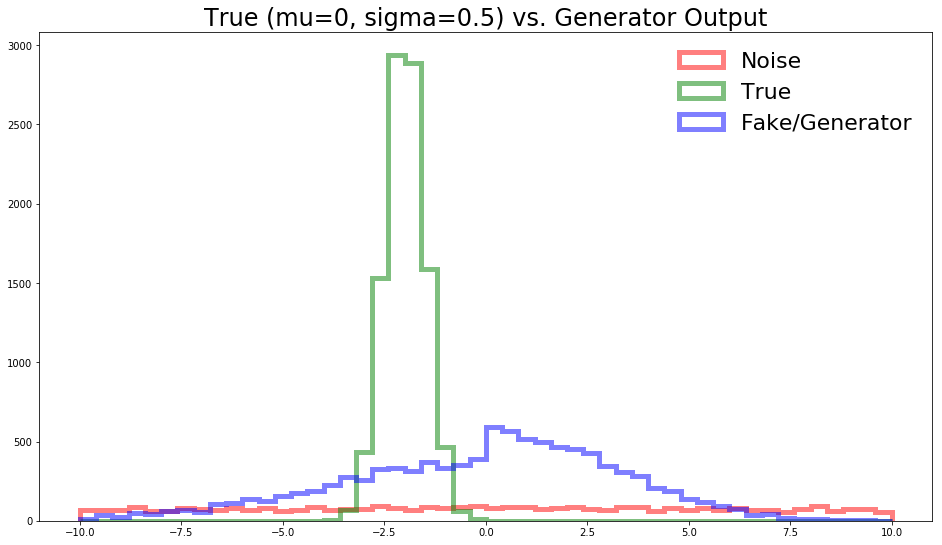

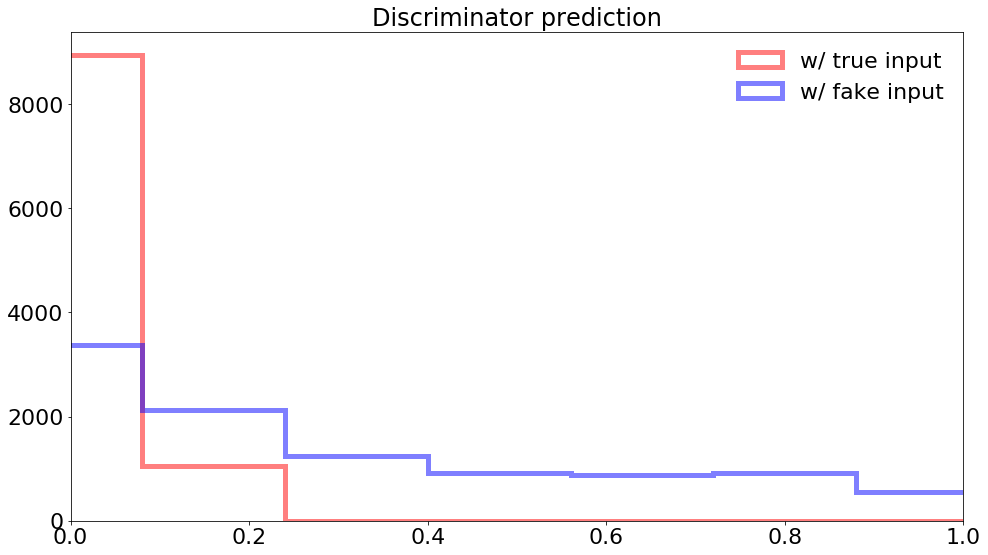

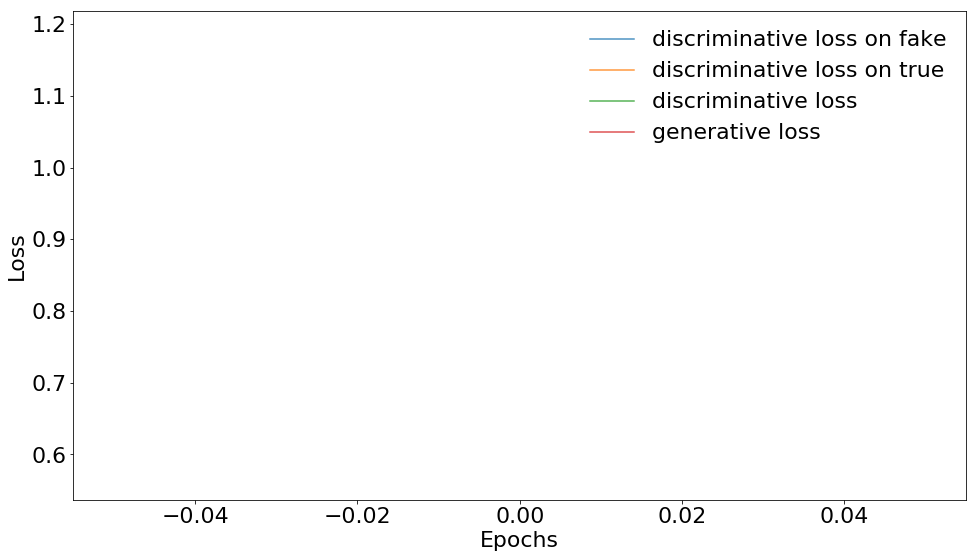

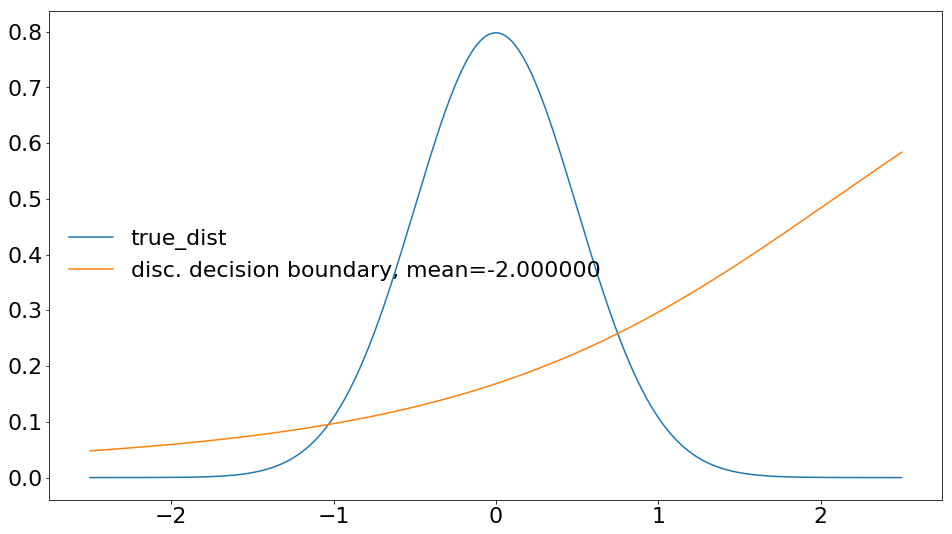

Epoch 1, Discriminator loss:0.597551763058, GAN loss:0.527337551117
For true: mean and s.d. =  -0.491209798833 0.497610043509
For generator: mean and s.d. =  -0.0621605 0.823928


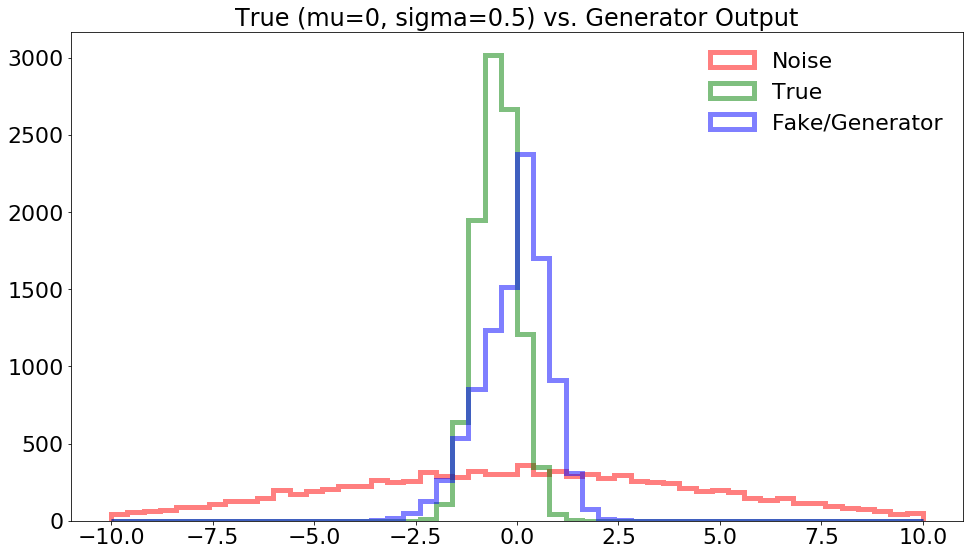

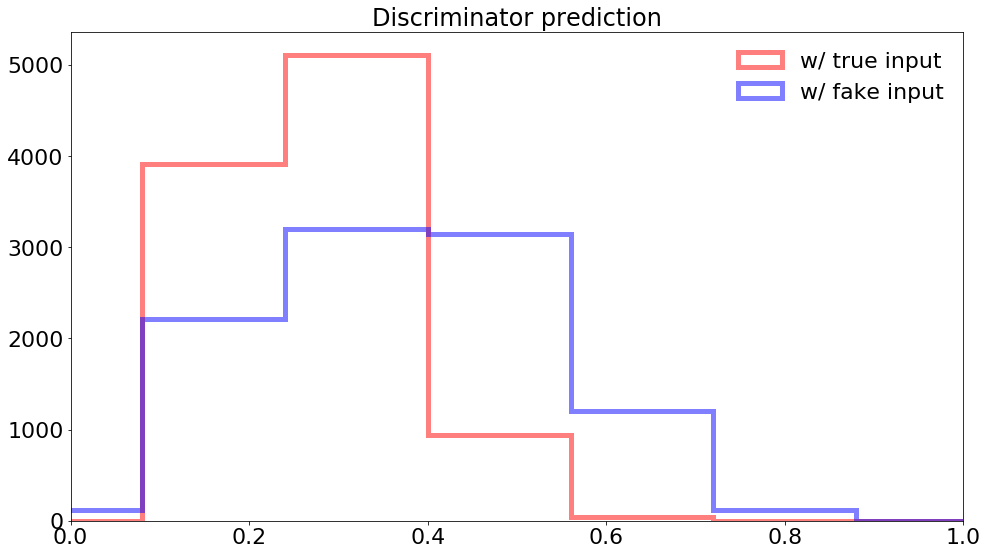

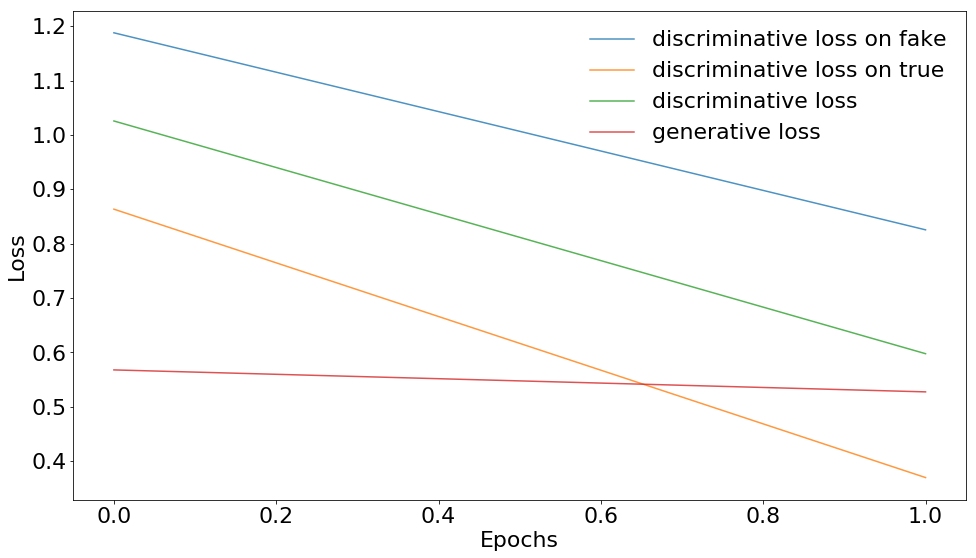

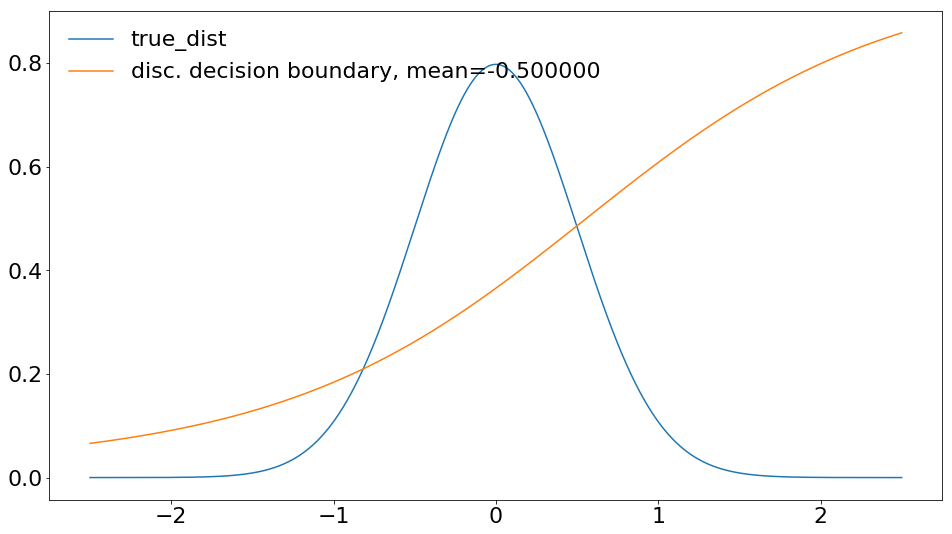

Epoch 1, Discriminator loss:1.12486076355, GAN loss:0.775670528412
For true: mean and s.d. =  0.496692625417 0.494312121003
For generator: mean and s.d. =  -0.245501 0.815064


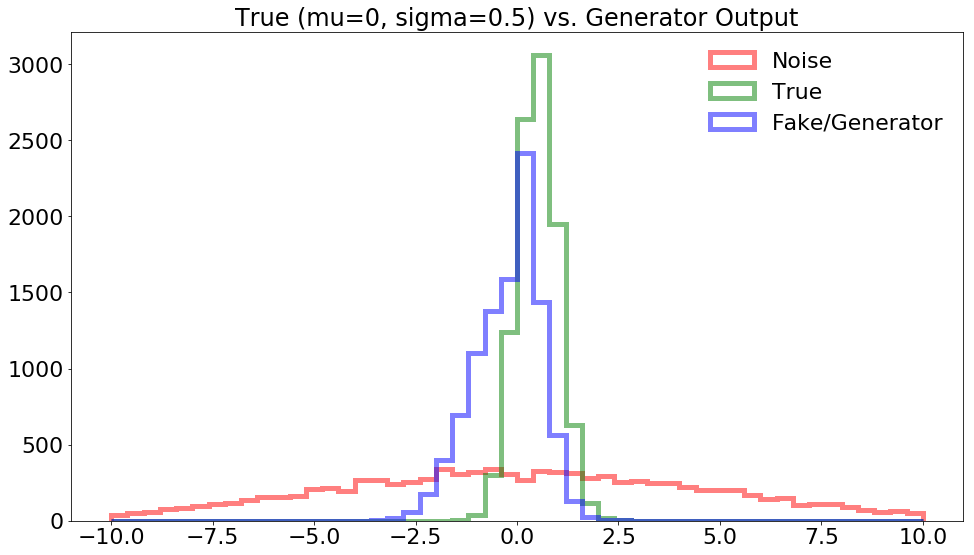

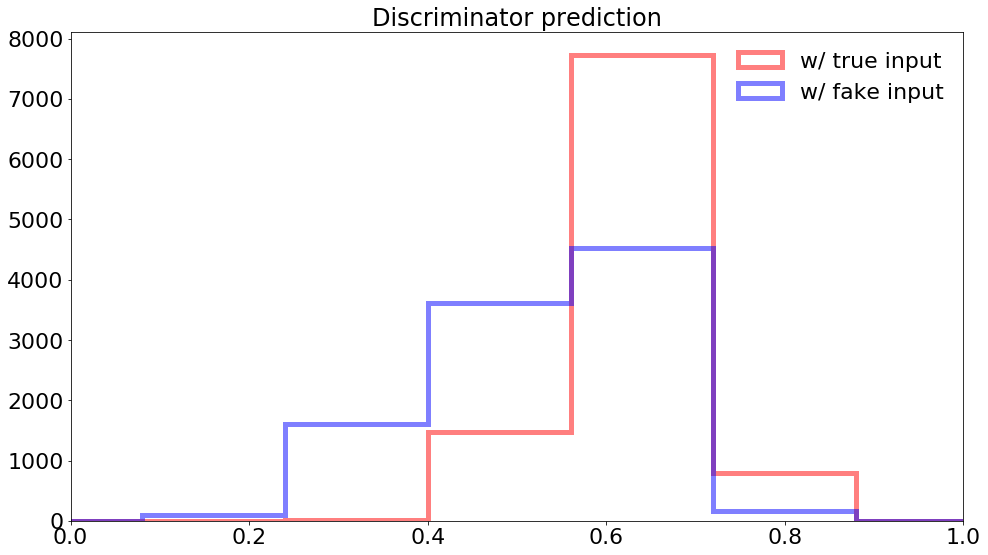

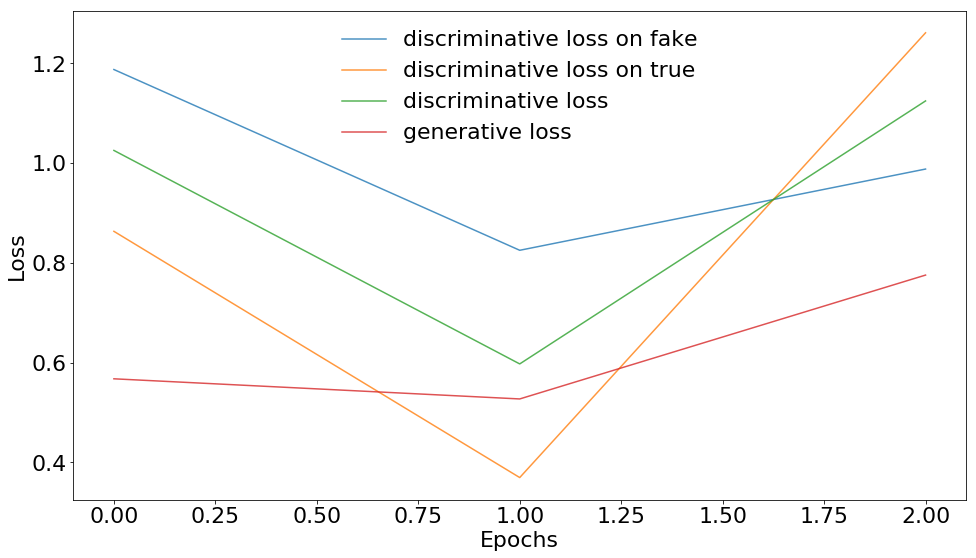

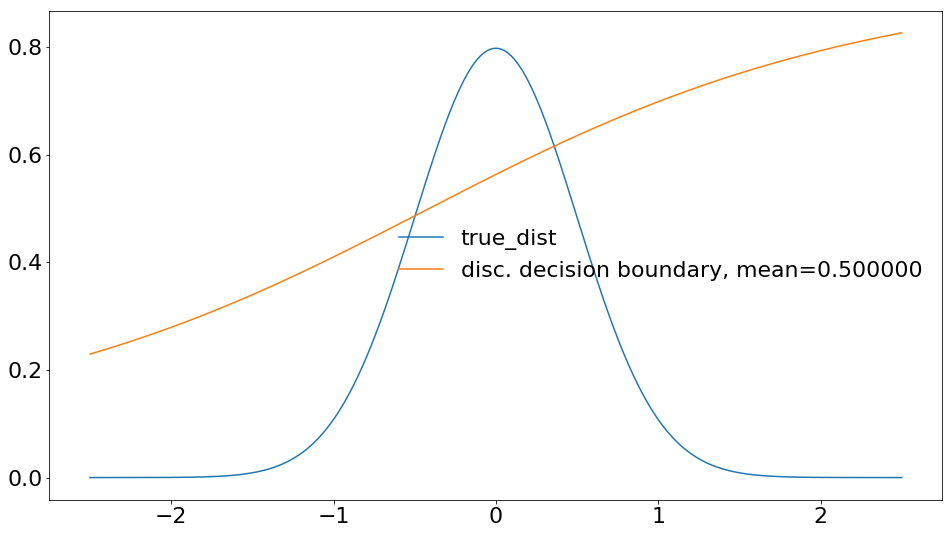

Epoch 1, Discriminator loss:1.44857108593, GAN loss:0.616427481174
For true: mean and s.d. =  1.9941482552 0.497201068932
For generator: mean and s.d. =  -0.990675 3.09556


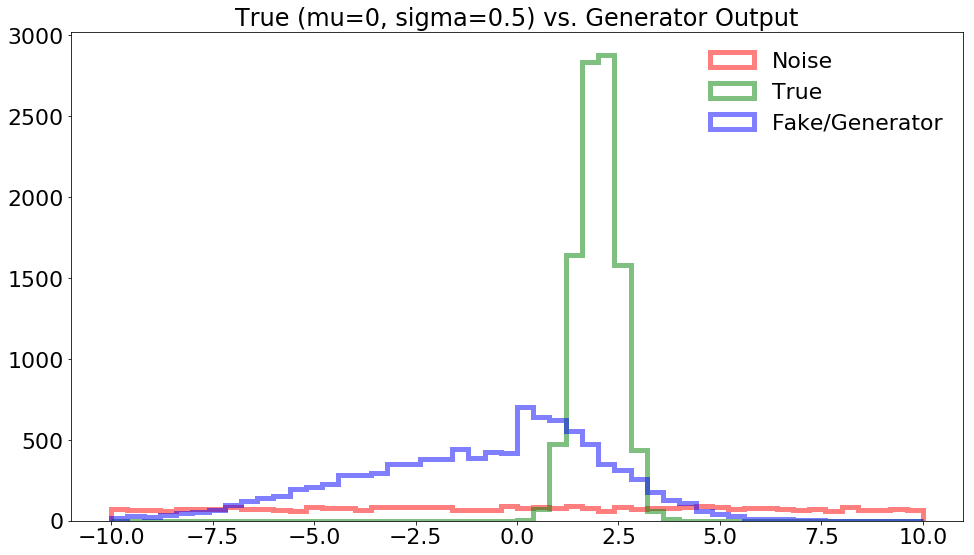

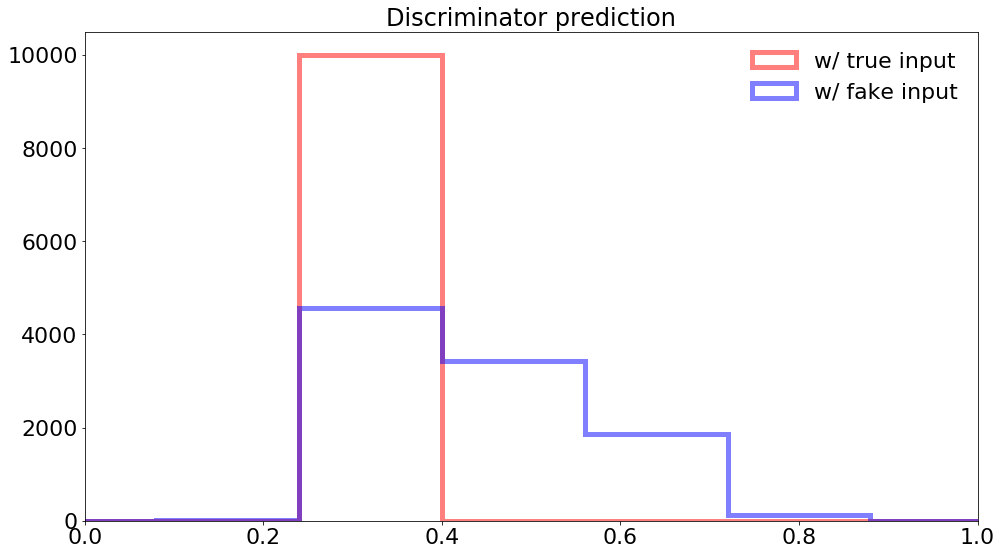

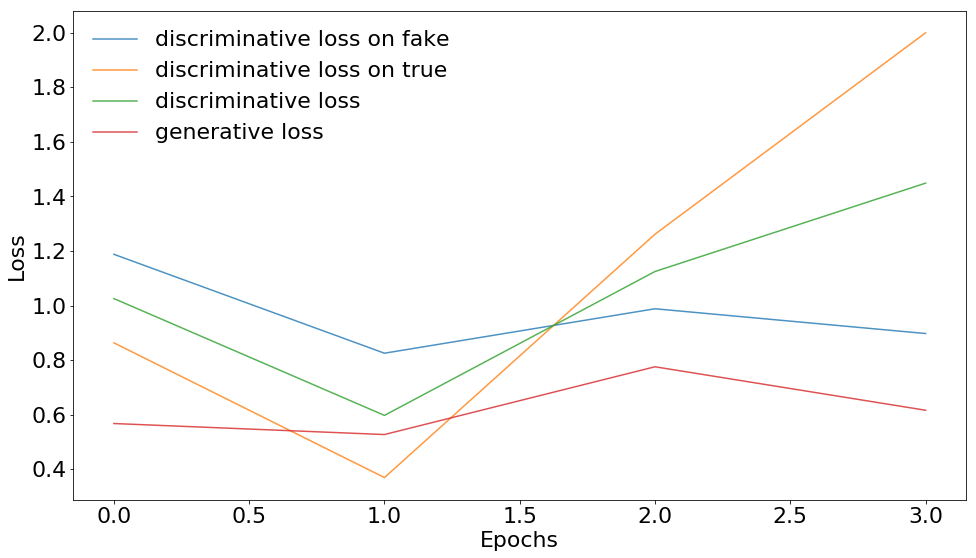

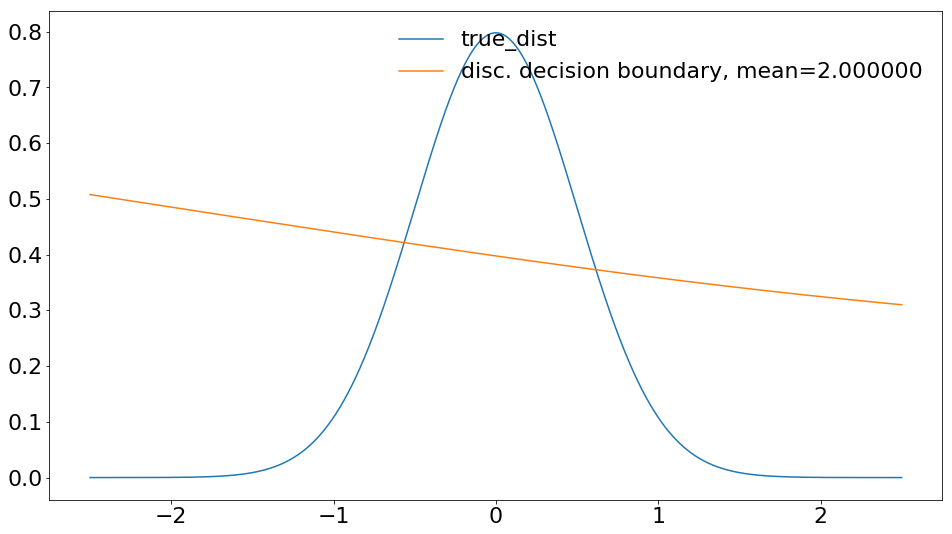

Epoch 101, Discriminator loss:0.686994433403, GAN loss:0.689100027084
For true: mean and s.d. =  -2.01015766018 0.495244761516
For generator: mean and s.d. =  0.29716 3.66867


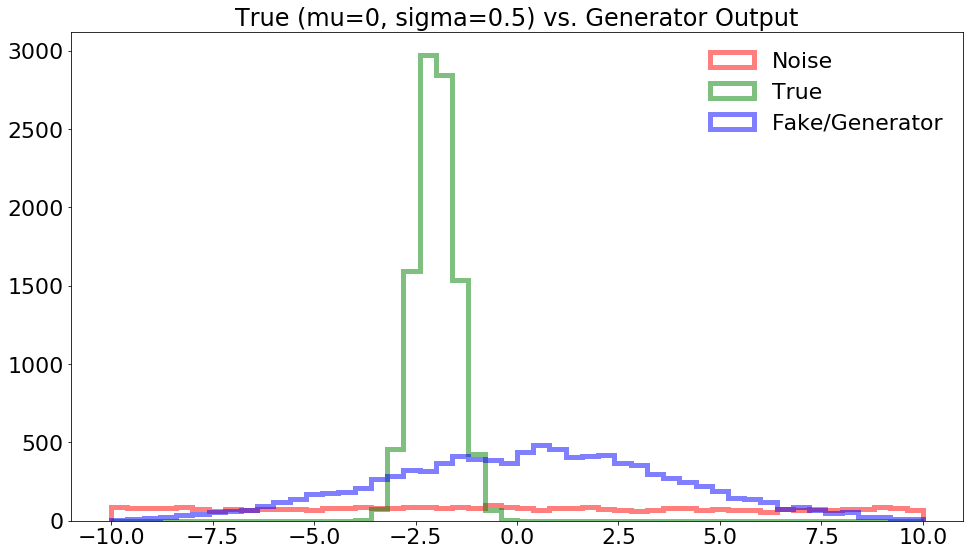

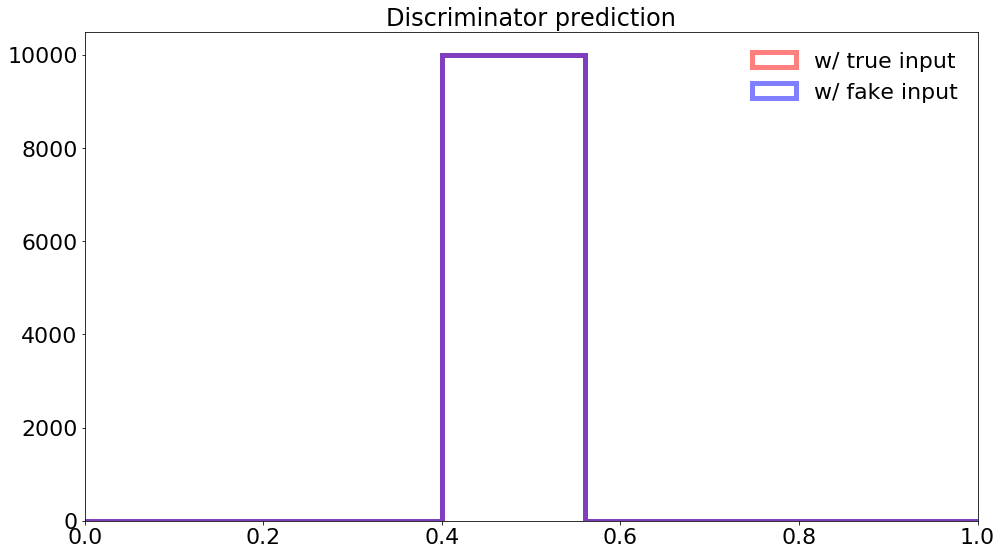

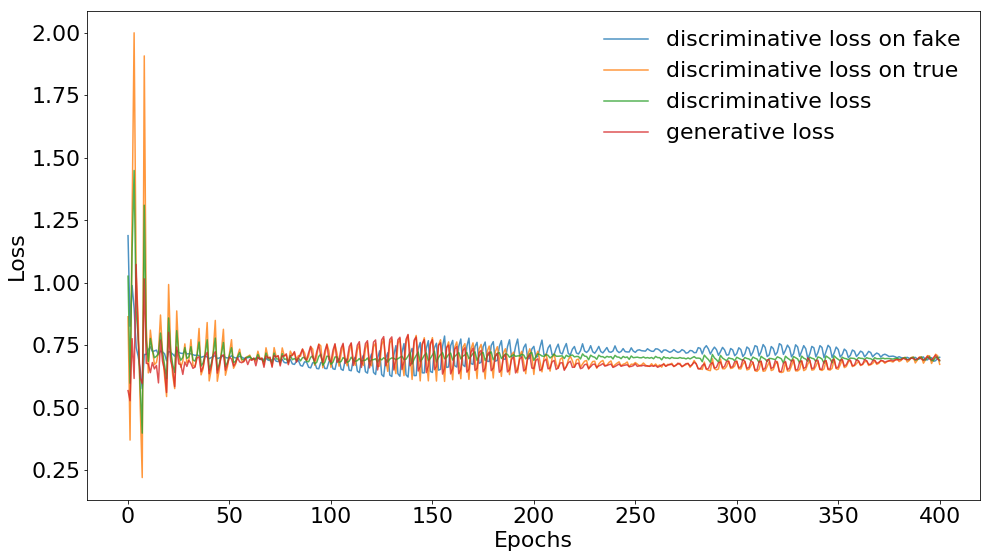

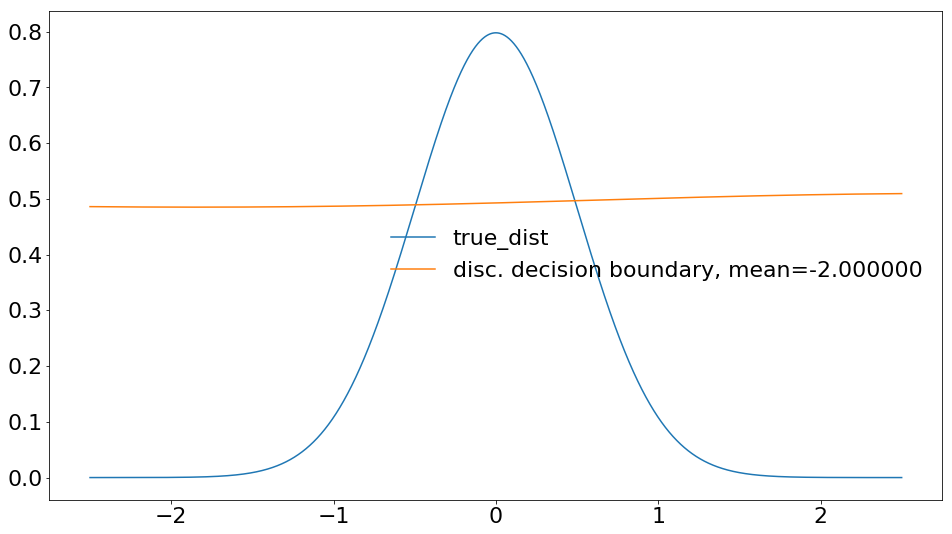

Epoch 101, Discriminator loss:0.688973069191, GAN loss:0.70372903347
For true: mean and s.d. =  -0.504907631369 0.498478046058
For generator: mean and s.d. =  0.0753857 0.920294


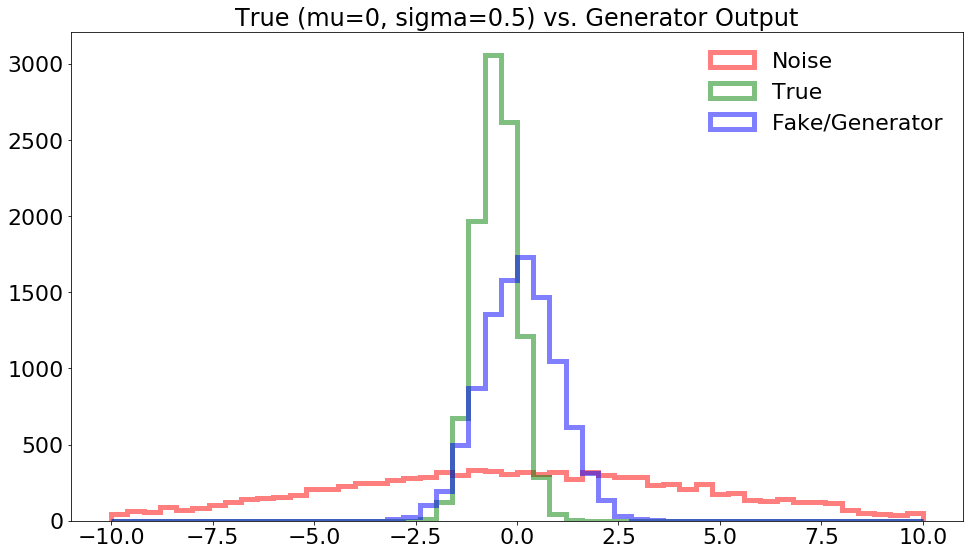

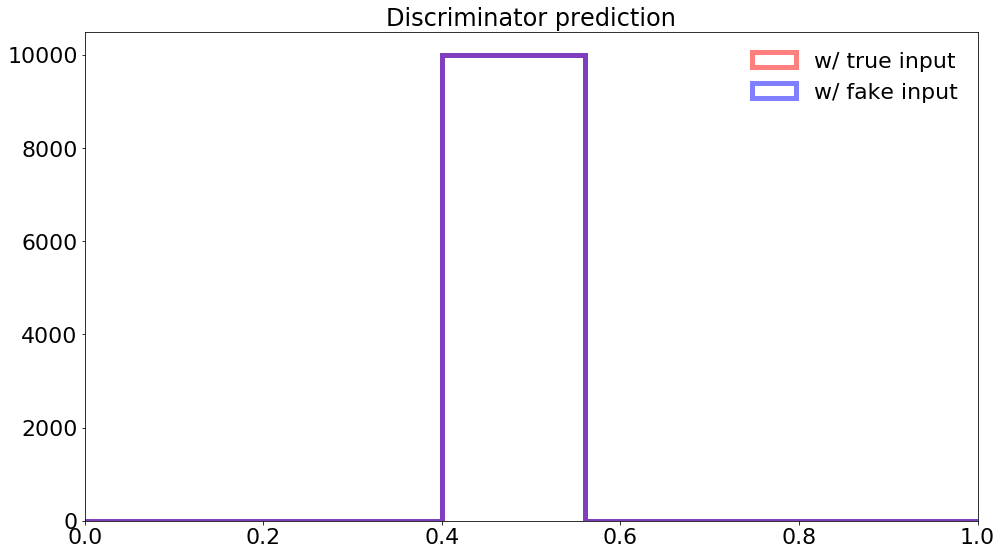

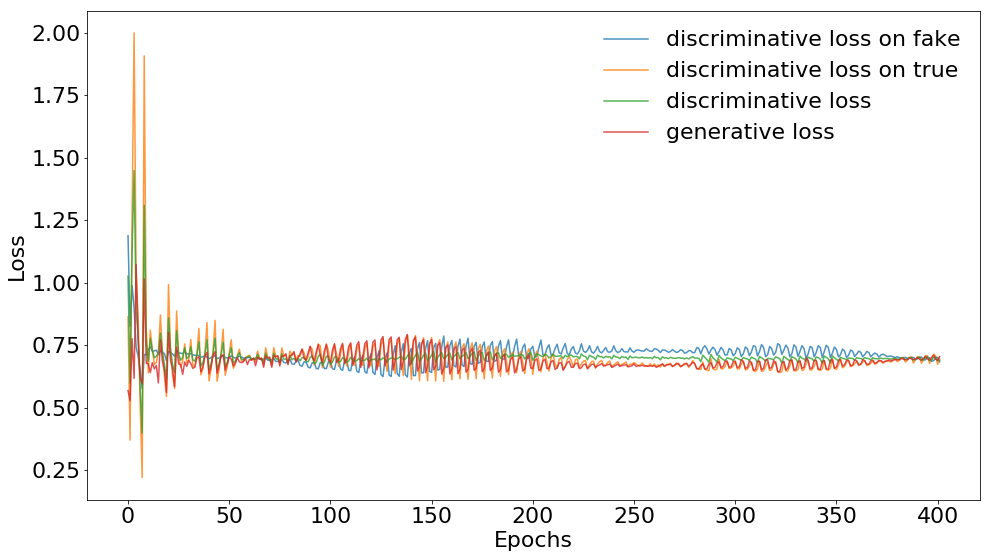

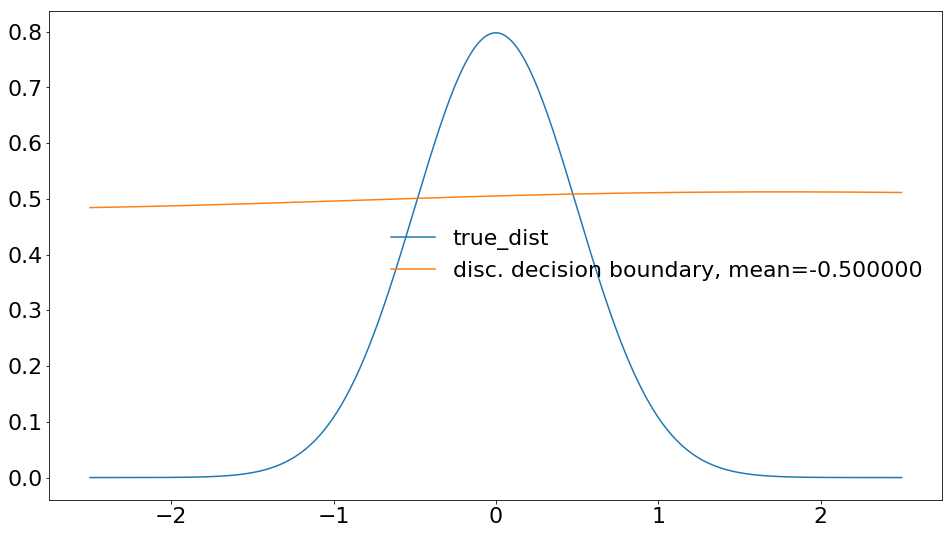

Epoch 101, Discriminator loss:0.700652897358, GAN loss:0.715700984001
For true: mean and s.d. =  0.507141953964 0.494999301175
For generator: mean and s.d. =  -0.104275 0.933274


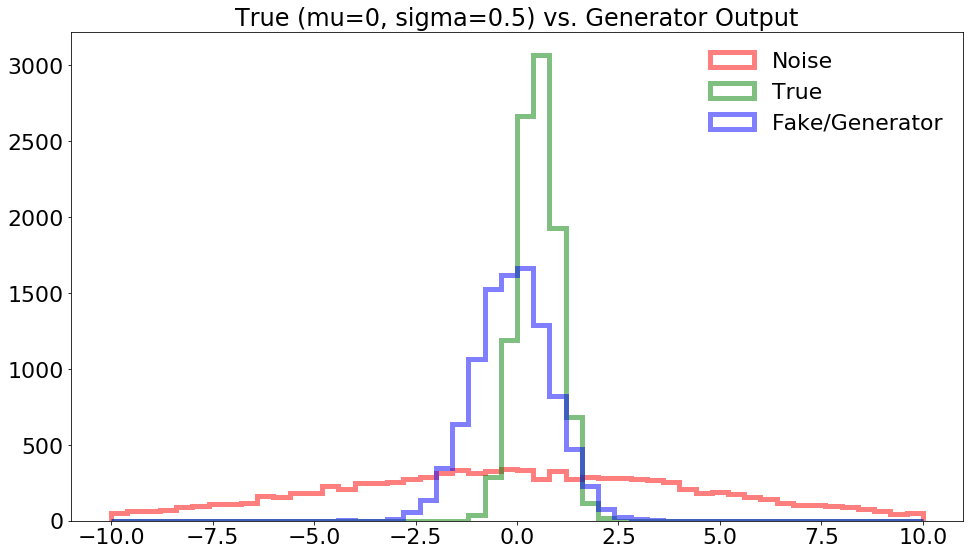

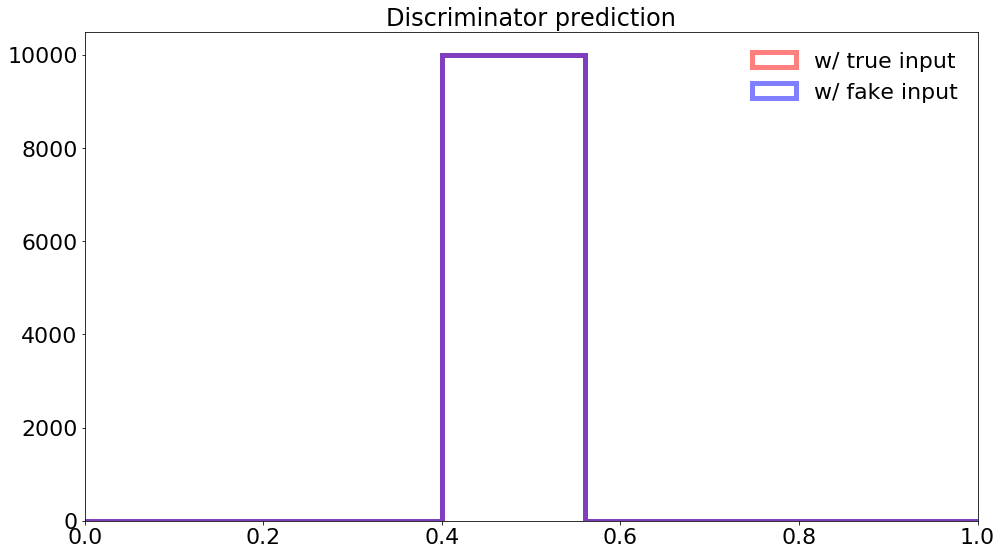

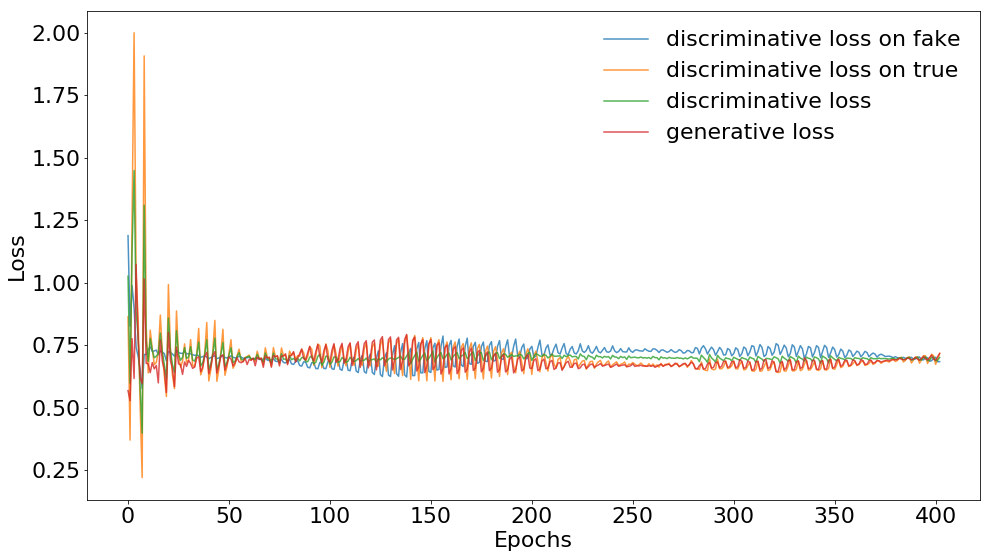

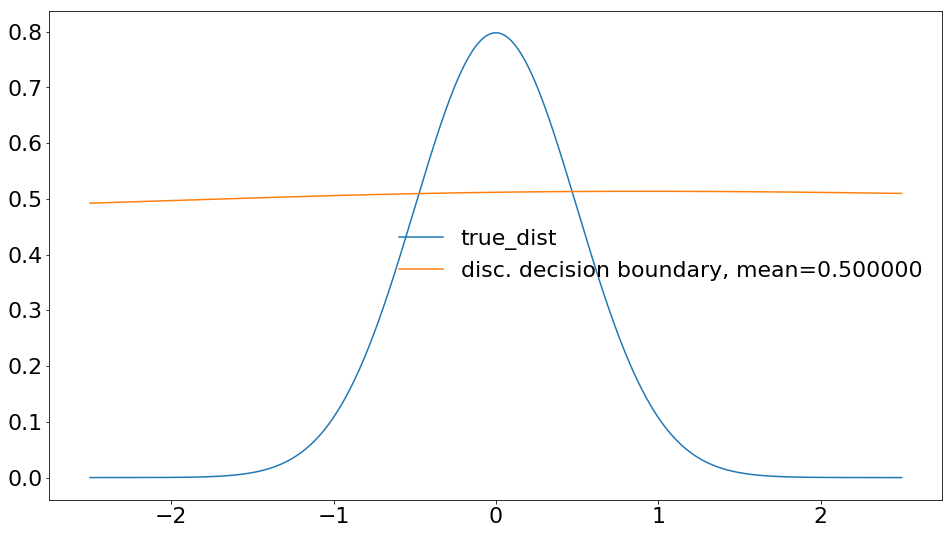

Epoch 101, Discriminator loss:0.704064011574, GAN loss:0.69294911623
For true: mean and s.d. =  1.99763423069 0.505026179047
For generator: mean and s.d. =  -0.396967 3.68203


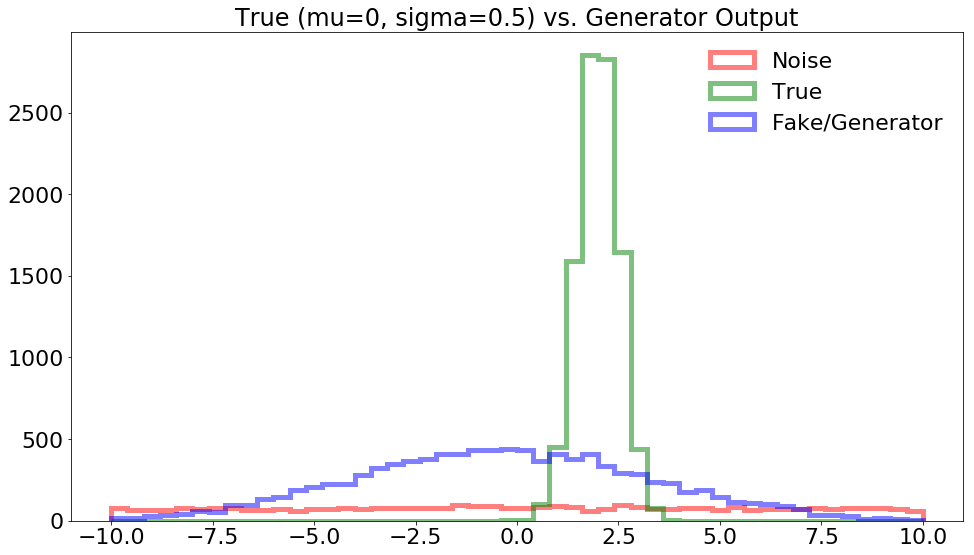

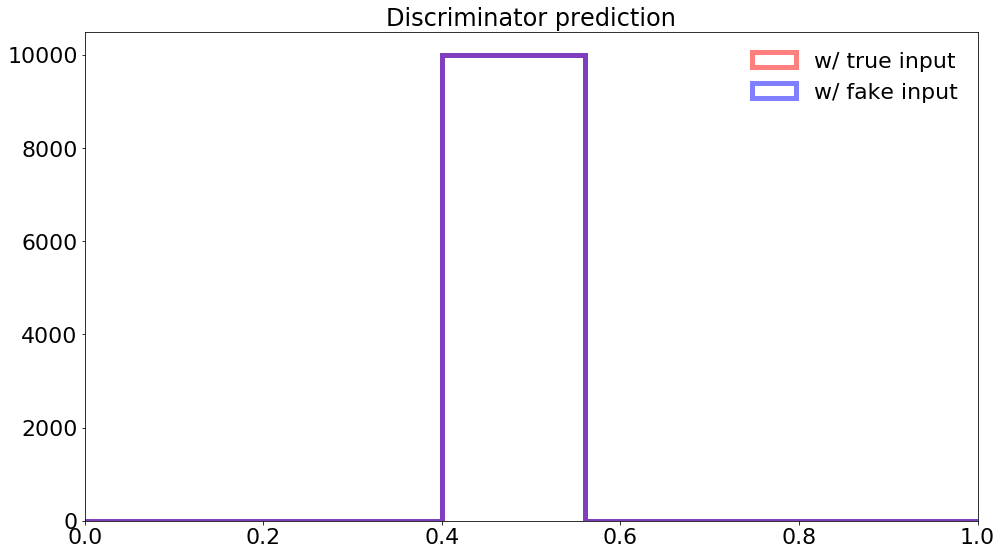

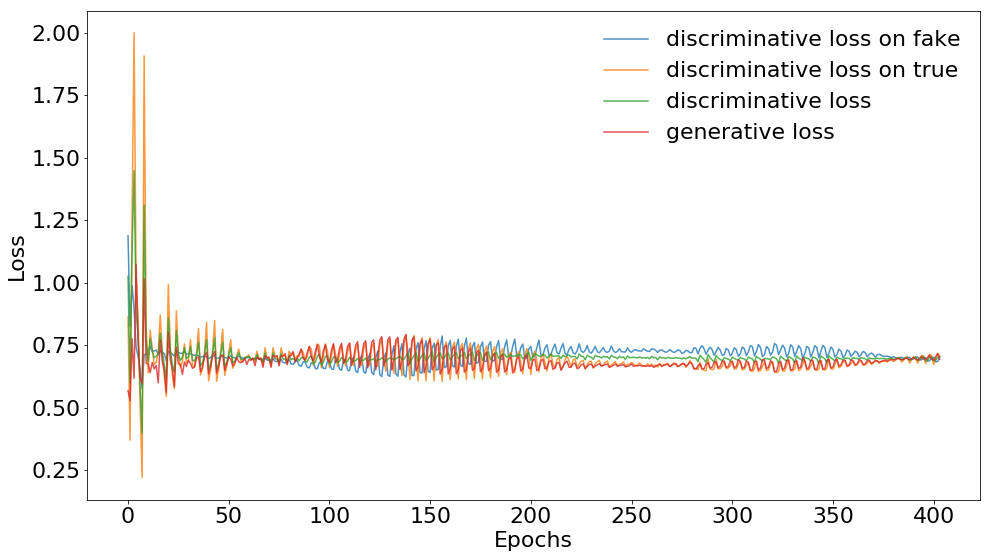

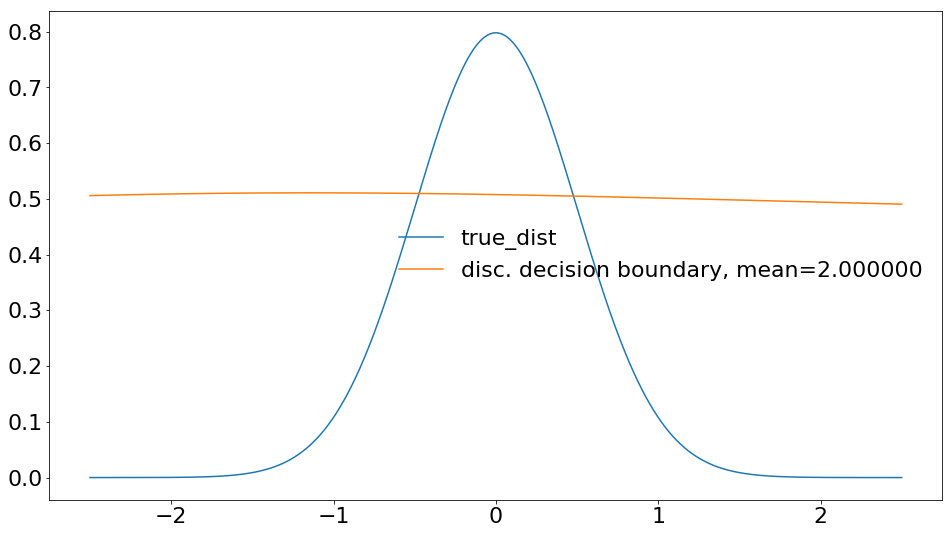

Epoch 201, Discriminator loss:0.598279833794, GAN loss:0.675900578499
For true: mean and s.d. =  -2.00633150469 0.499635609549
For generator: mean and s.d. =  0.586969 4.03787


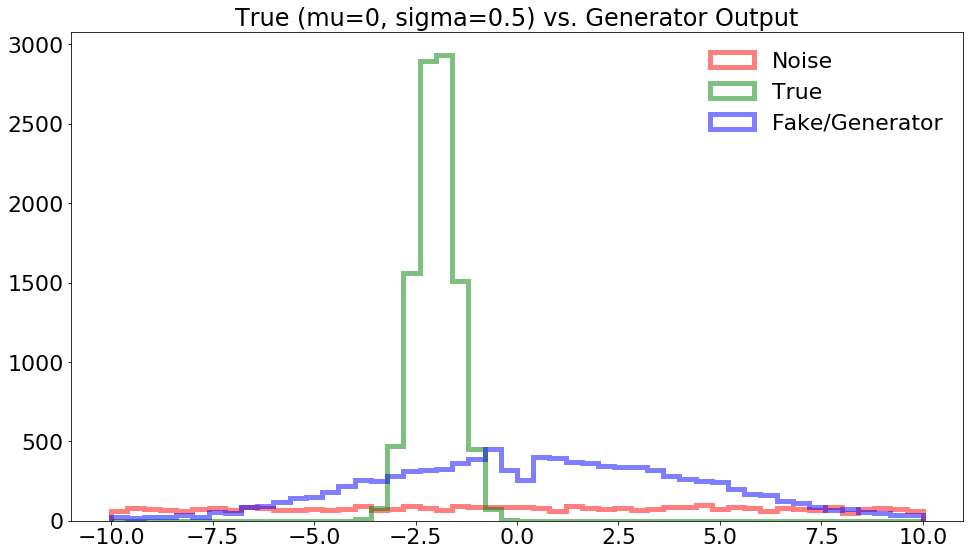

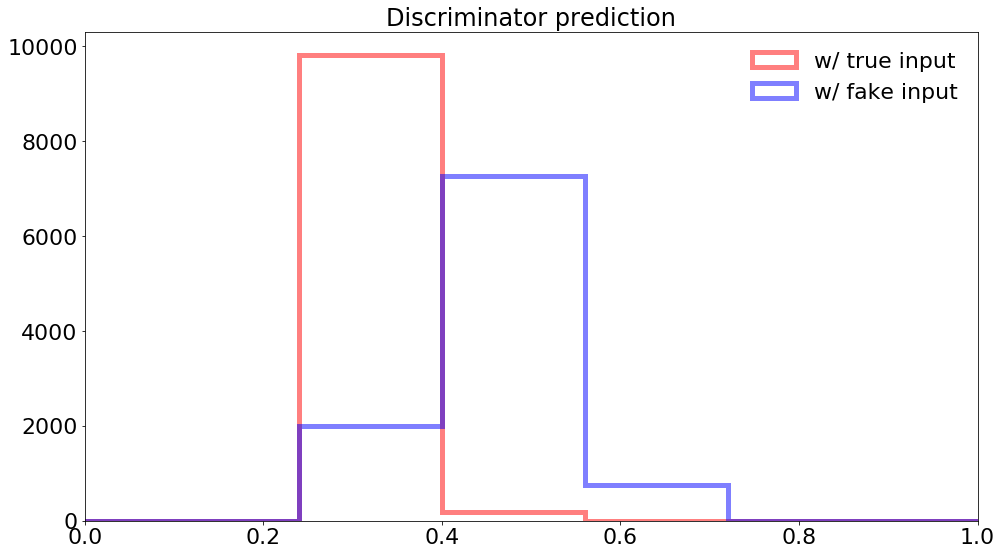

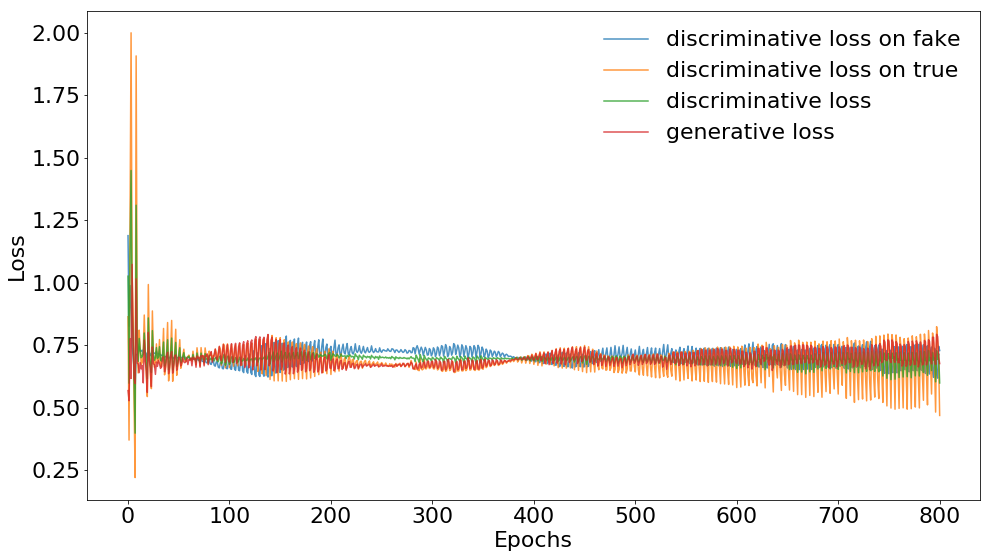

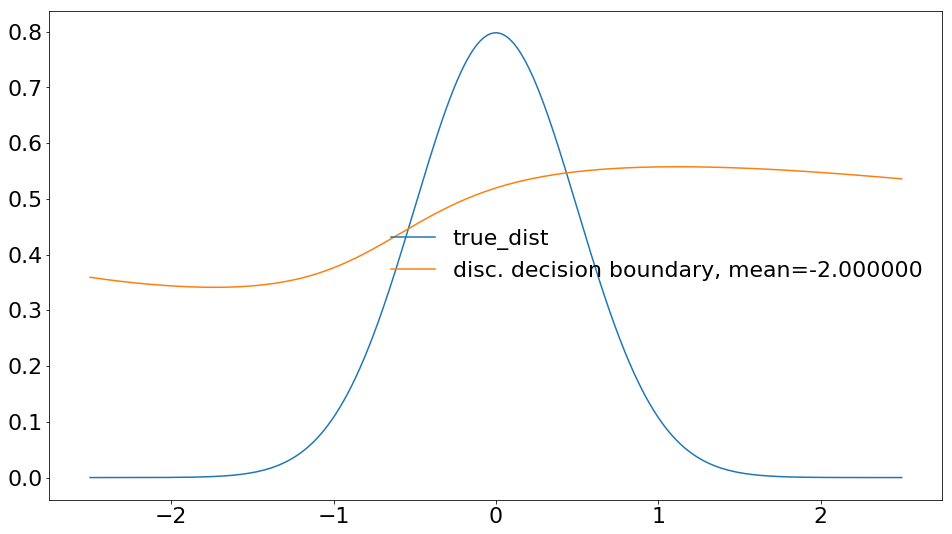

Epoch 201, Discriminator loss:0.721715033054, GAN loss:0.784852266312
For true: mean and s.d. =  -0.49531844706 0.508464246666
For generator: mean and s.d. =  0.179732 1.09023


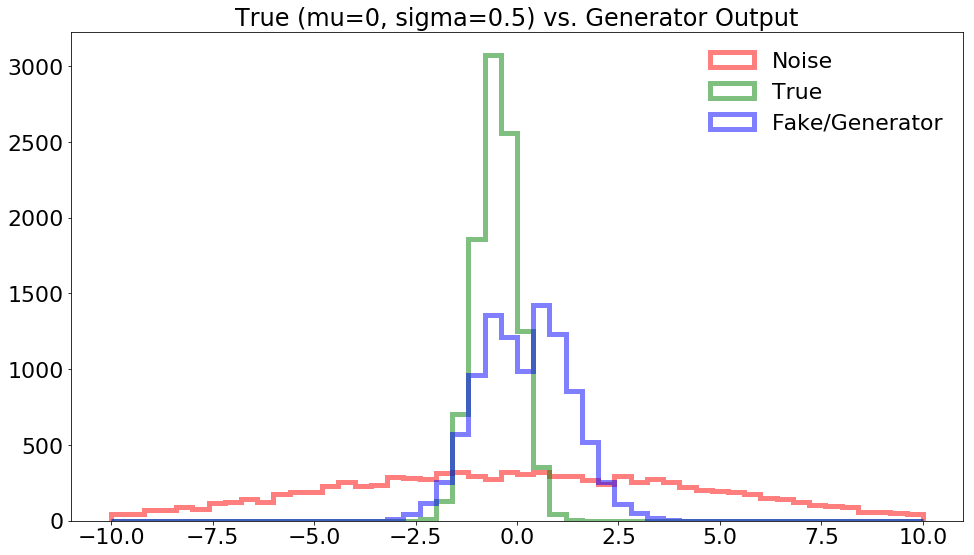

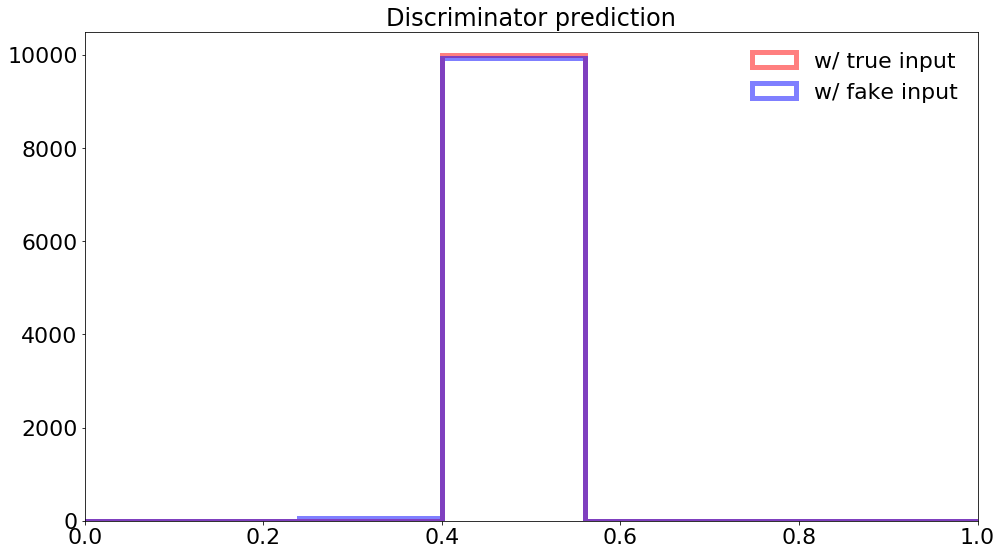

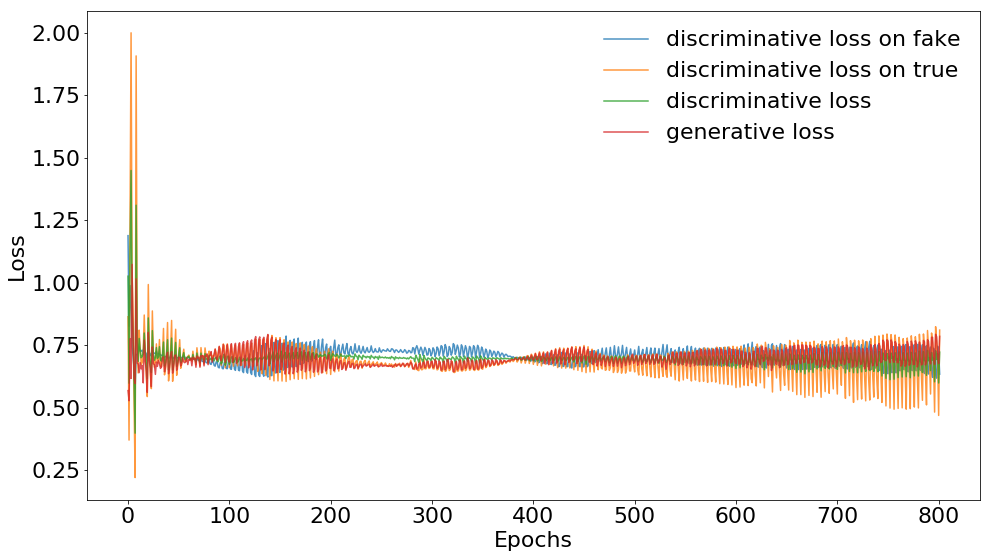

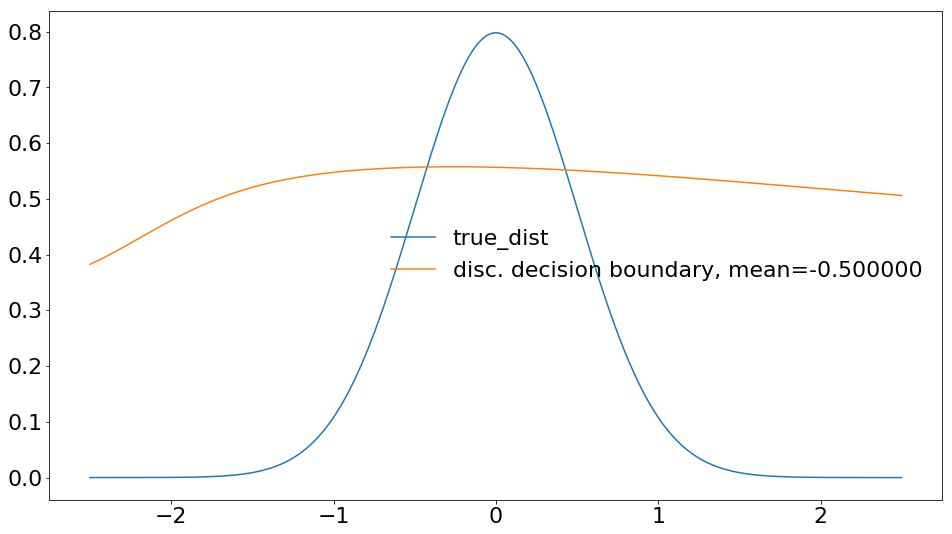

Epoch 201, Discriminator loss:0.69562536478, GAN loss:0.772687911987
For true: mean and s.d. =  0.509510344054 0.504401472912
For generator: mean and s.d. =  -0.0223589 1.08087


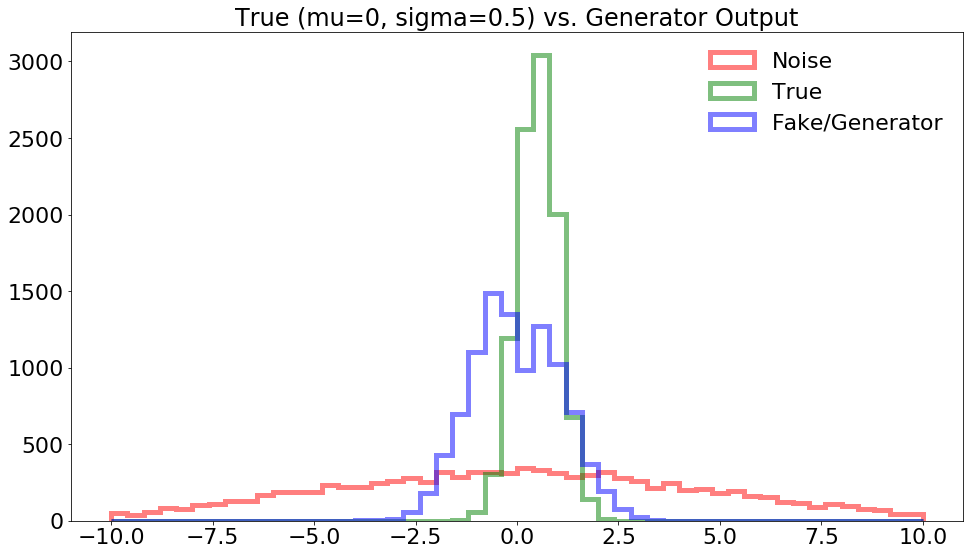

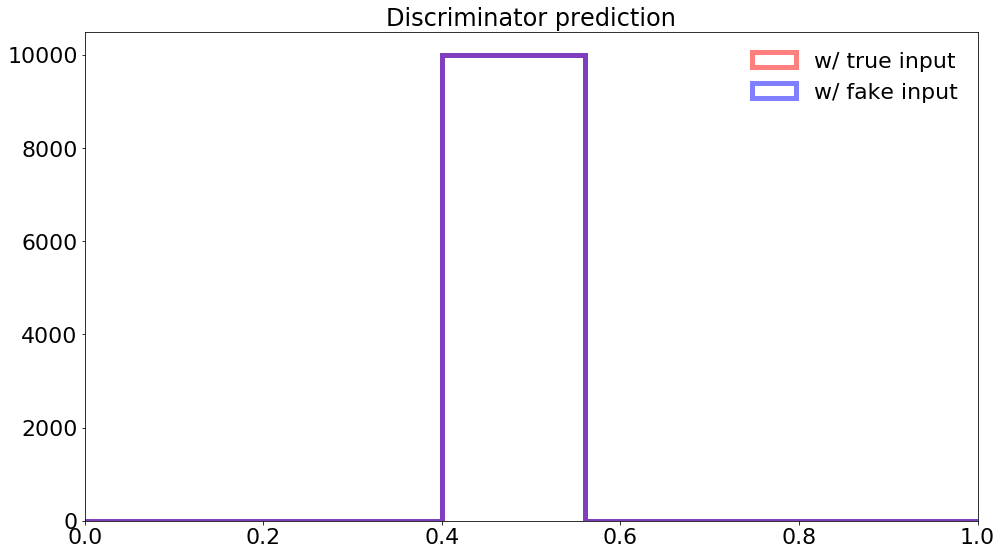

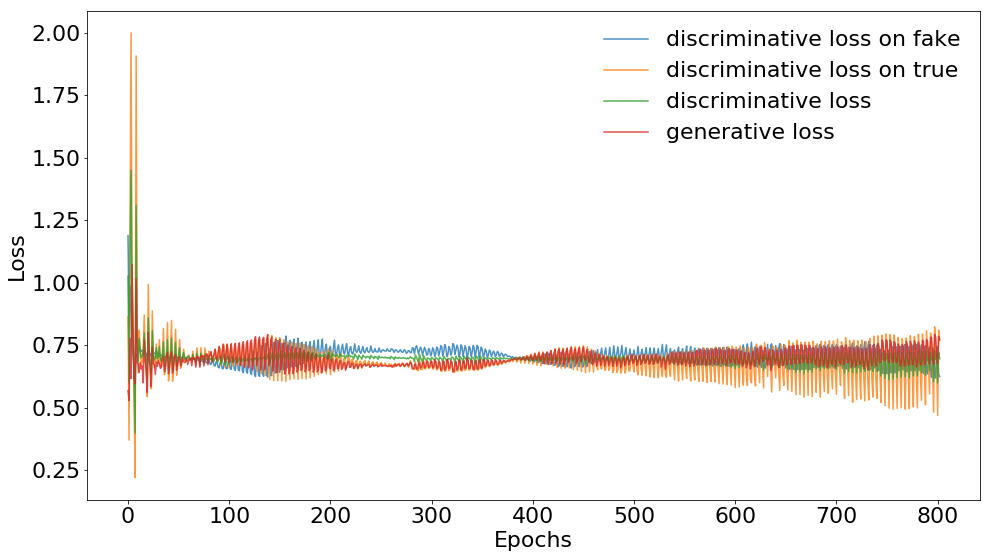

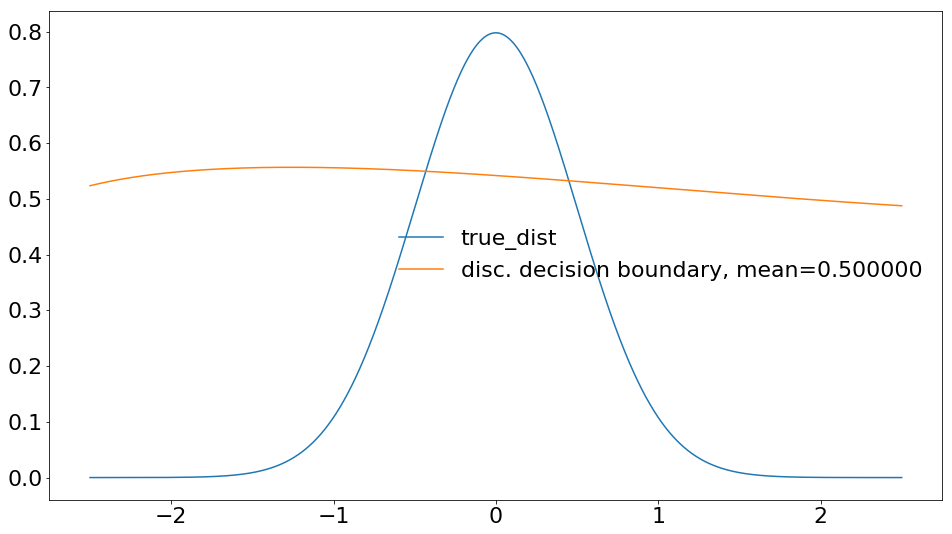

Epoch 201, Discriminator loss:0.711515426636, GAN loss:0.695173859596
For true: mean and s.d. =  1.99818506787 0.502887735826
For generator: mean and s.d. =  -0.256572 4.08013


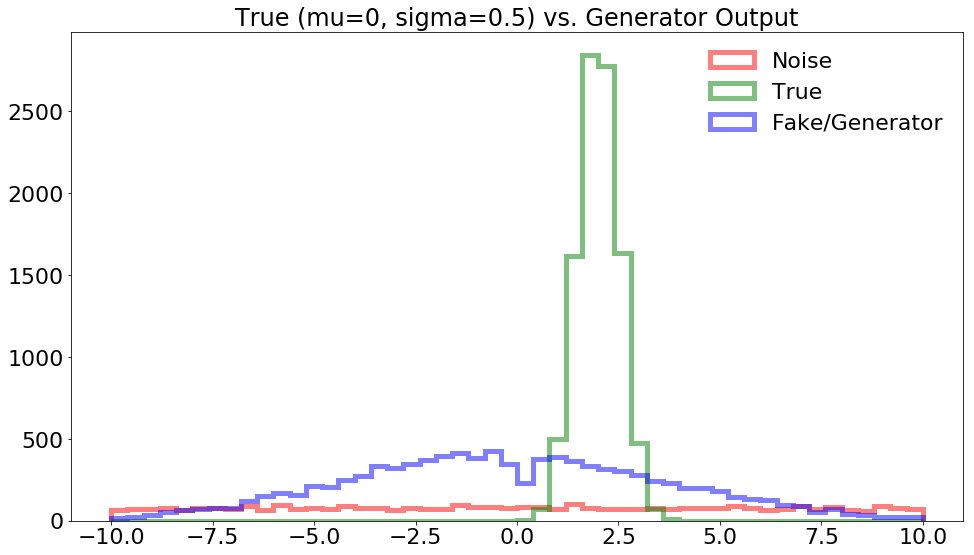

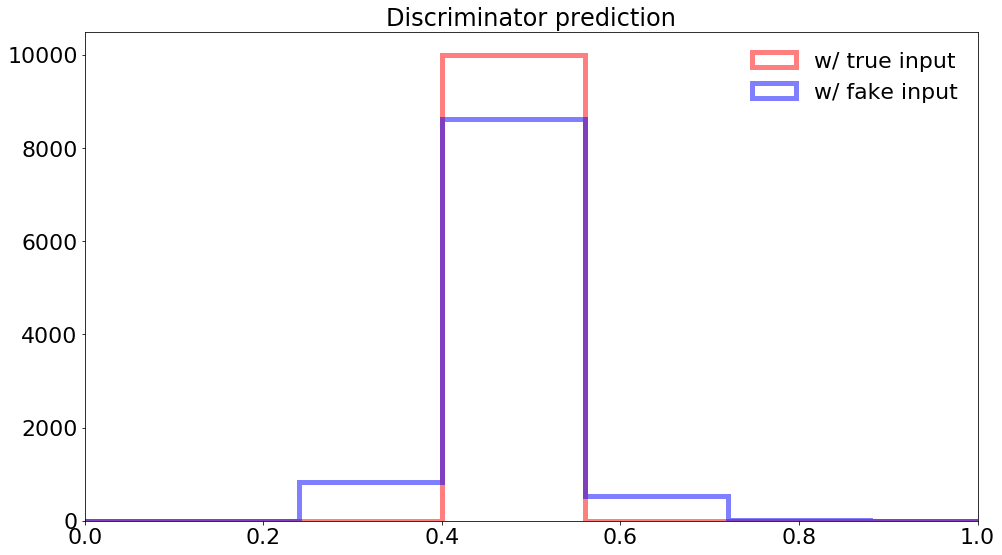

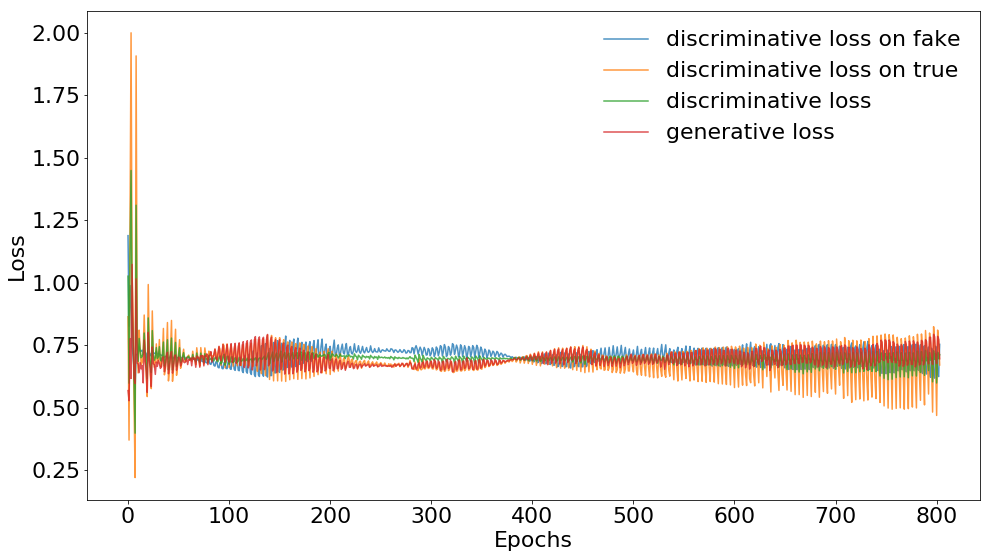

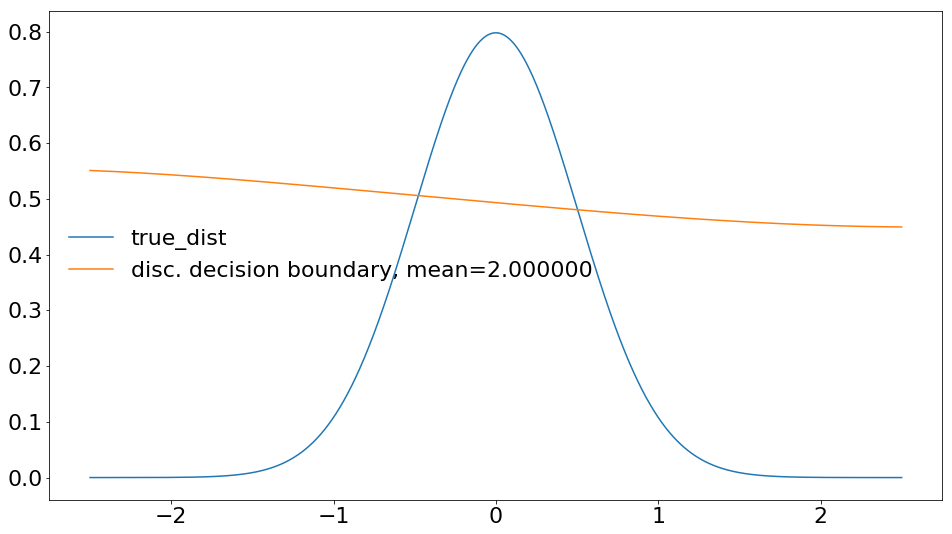

Epoch 301, Discriminator loss:0.526868224144, GAN loss:0.677131056786
For true: mean and s.d. =  -1.99867389108 0.494544024568
For generator: mean and s.d. =  0.548502 3.4989


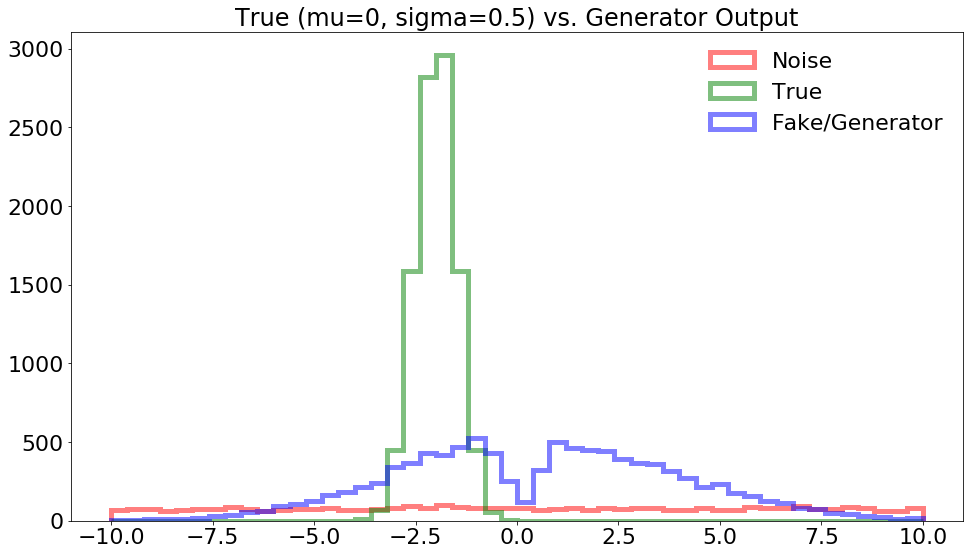

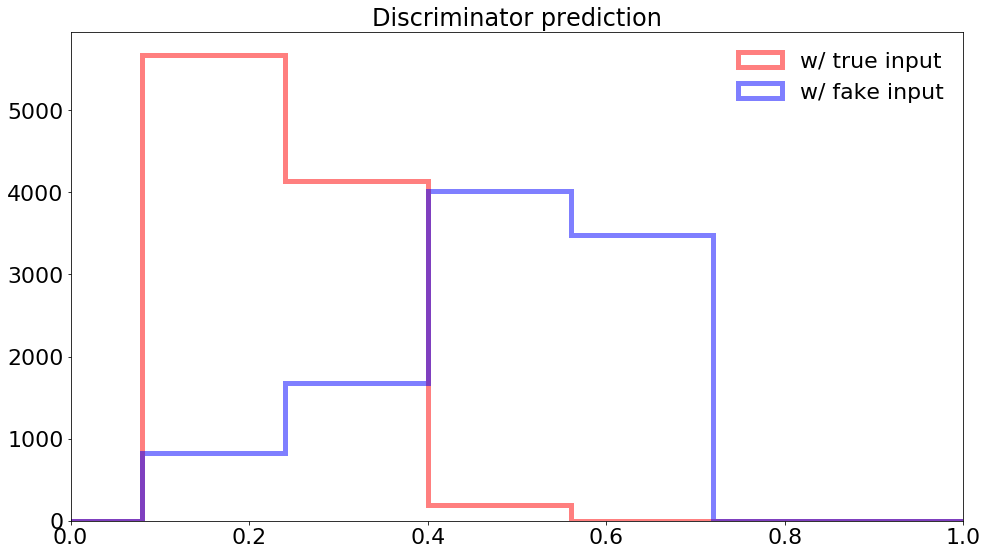

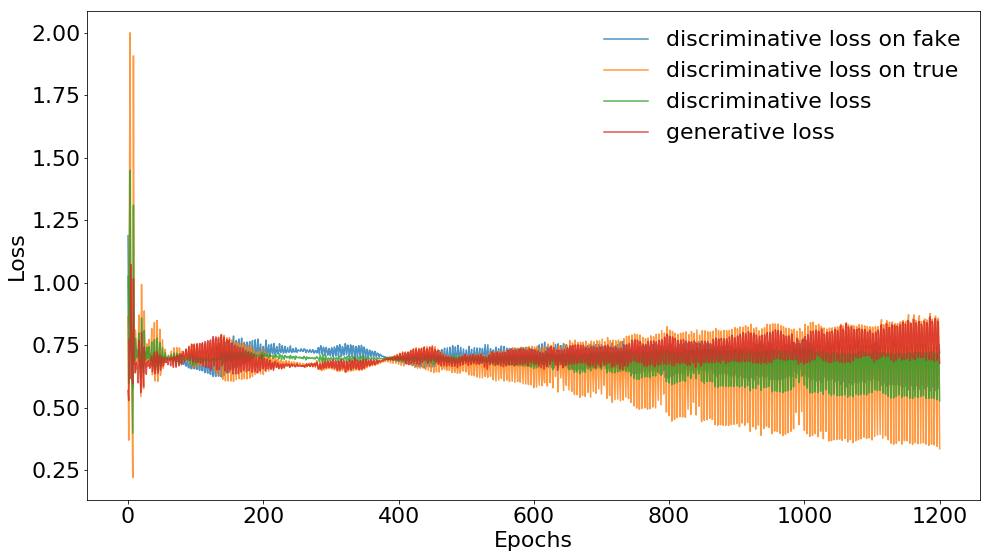

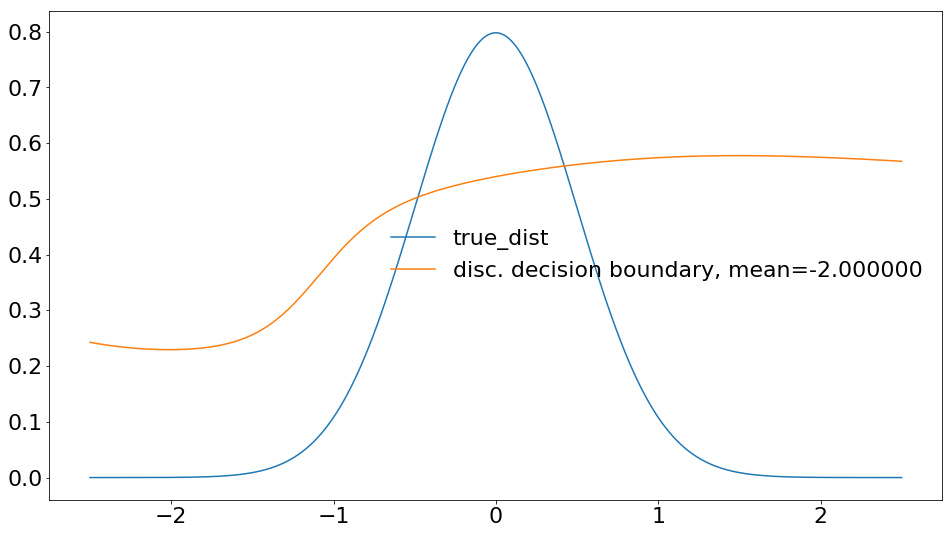

Epoch 301, Discriminator loss:0.717294335365, GAN loss:0.852438688278
For true: mean and s.d. =  -0.493171233322 0.497587035542
For generator: mean and s.d. =  0.272747 1.08802


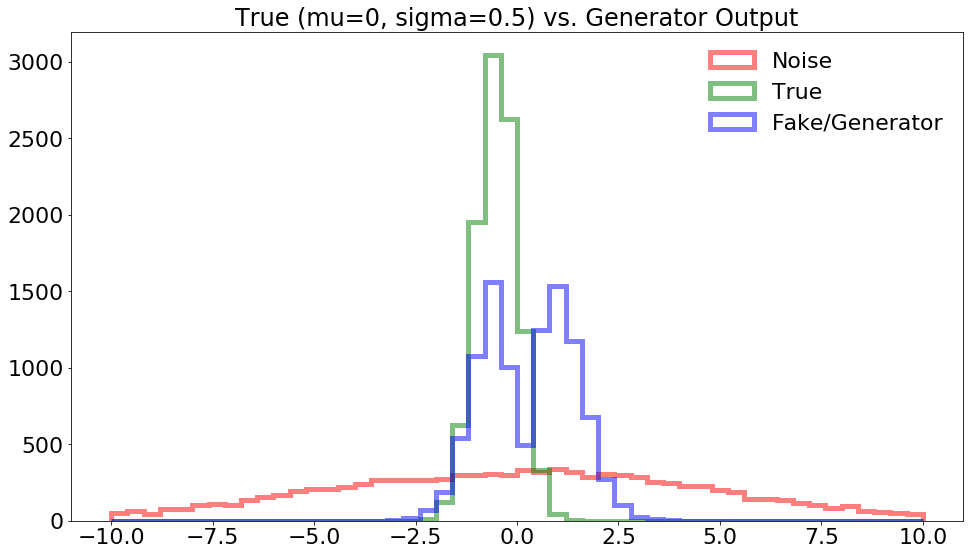

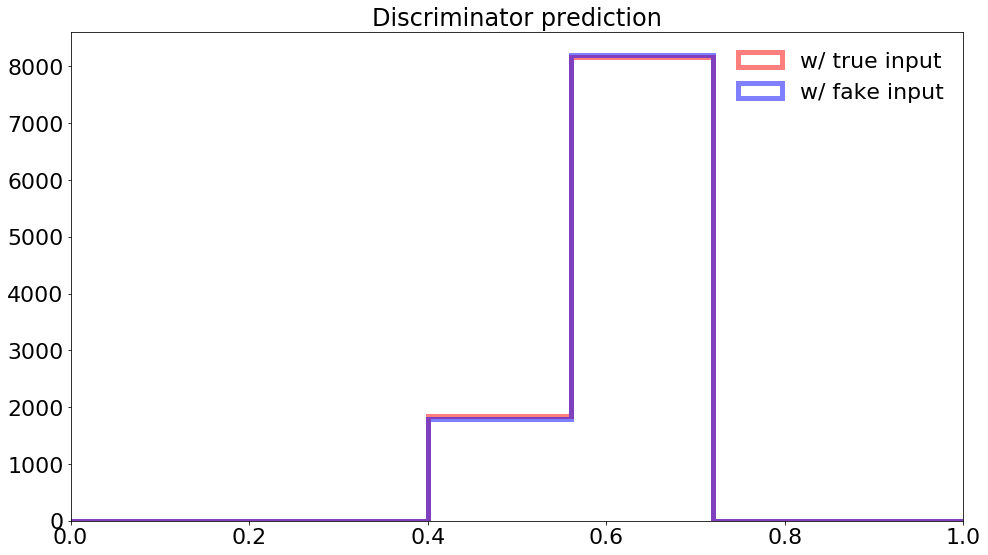

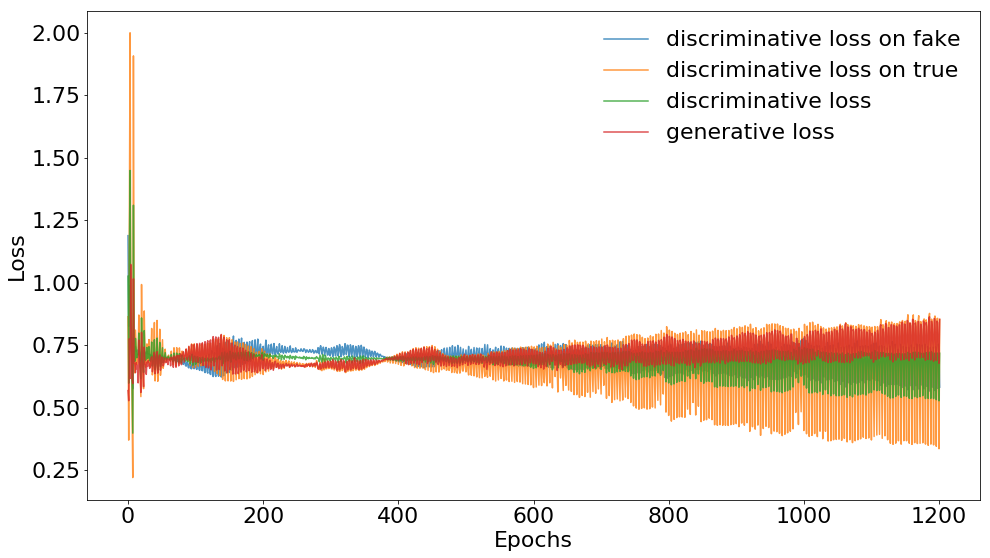

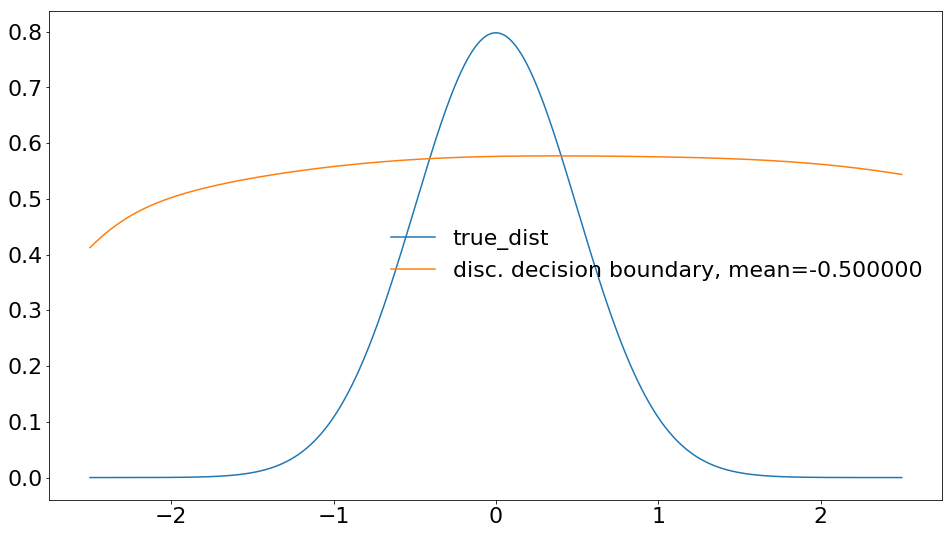

Epoch 301, Discriminator loss:0.715573489666, GAN loss:0.849302470684
For true: mean and s.d. =  0.500526755909 0.495477366277
For generator: mean and s.d. =  0.0557669 1.10892


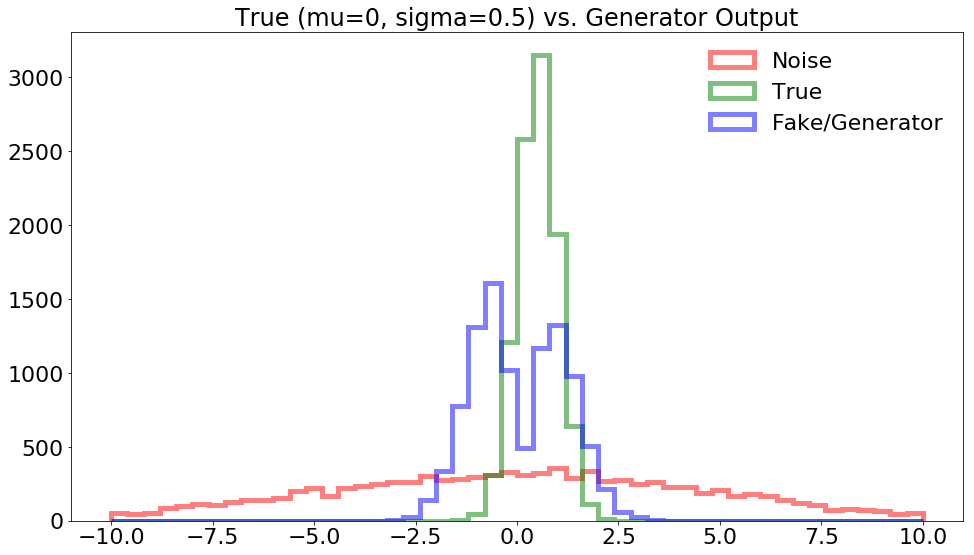

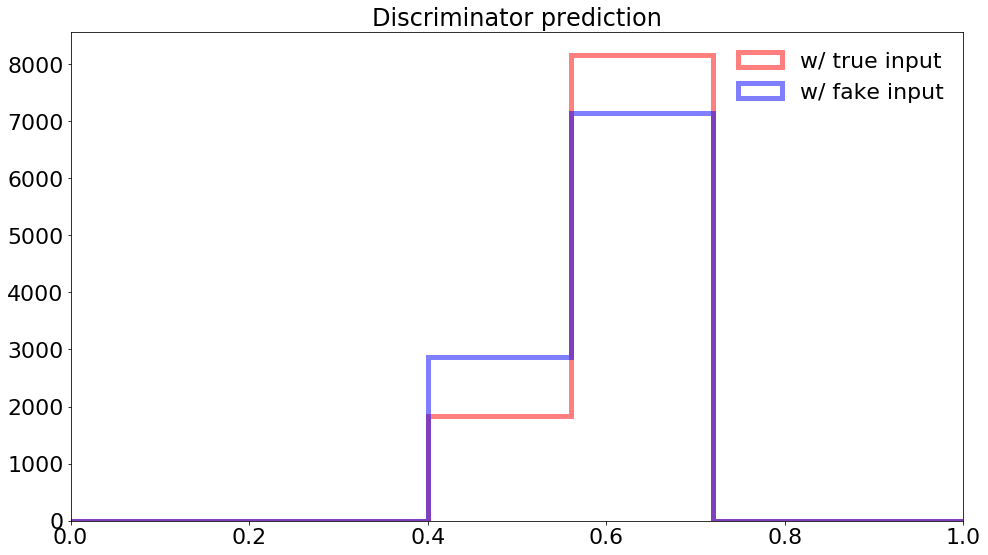

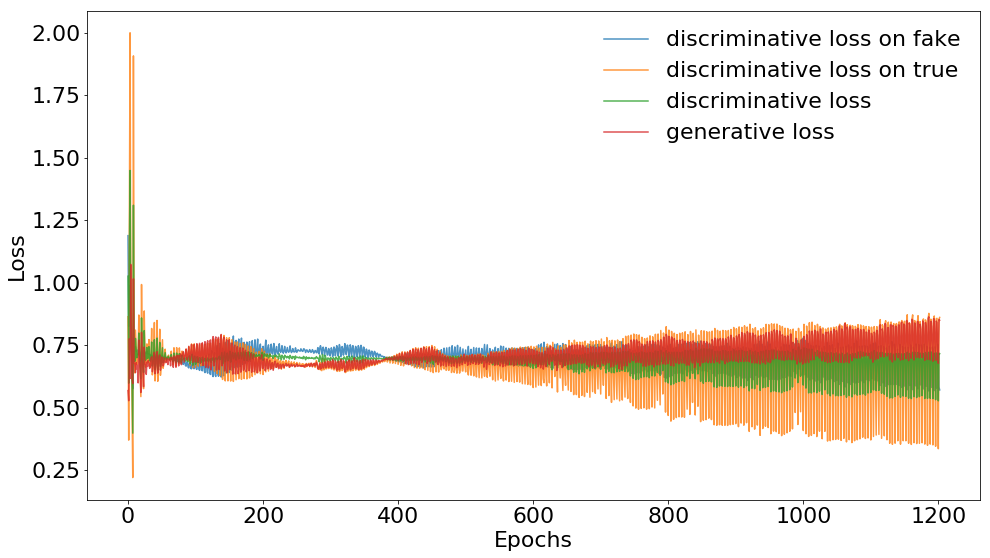

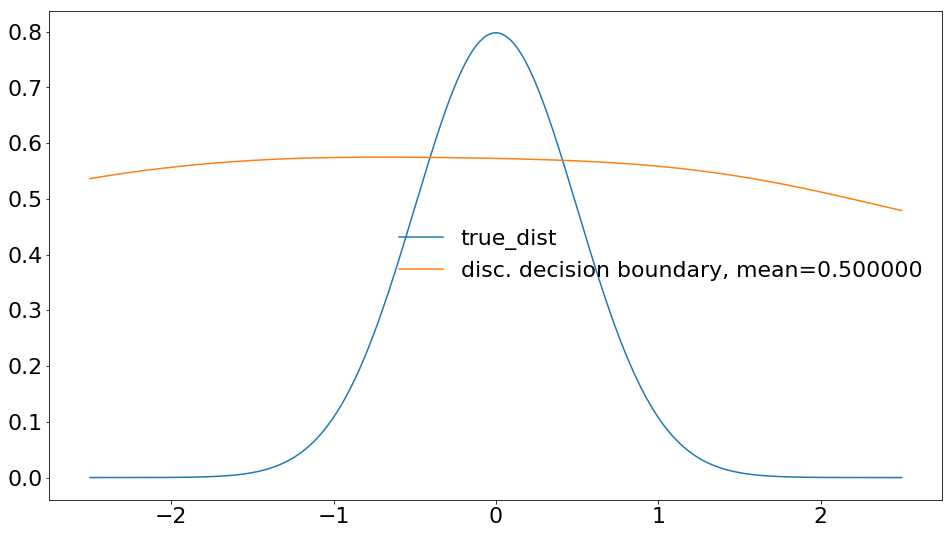

Epoch 301, Discriminator loss:0.697907209396, GAN loss:0.732560217381
For true: mean and s.d. =  2.00955501642 0.503274220882
For generator: mean and s.d. =  -0.152029 3.61756


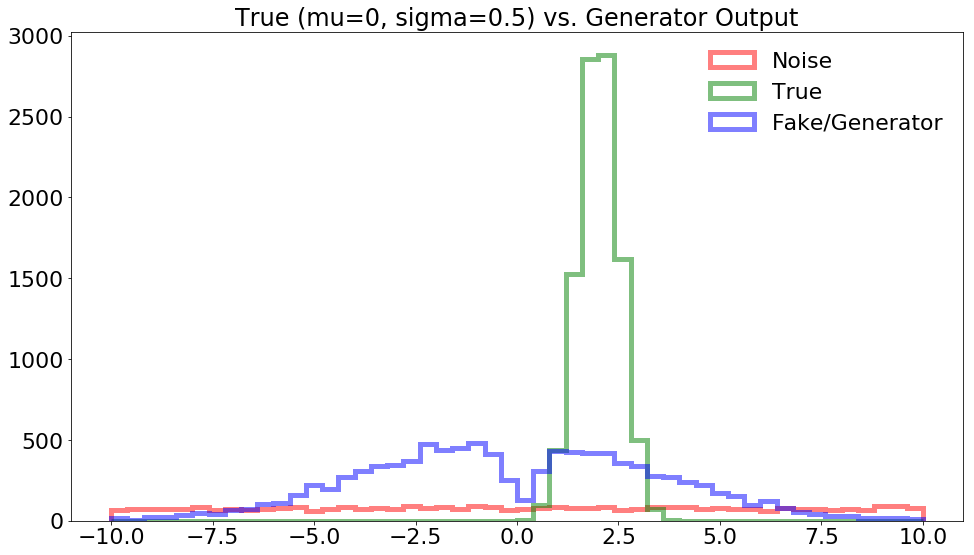

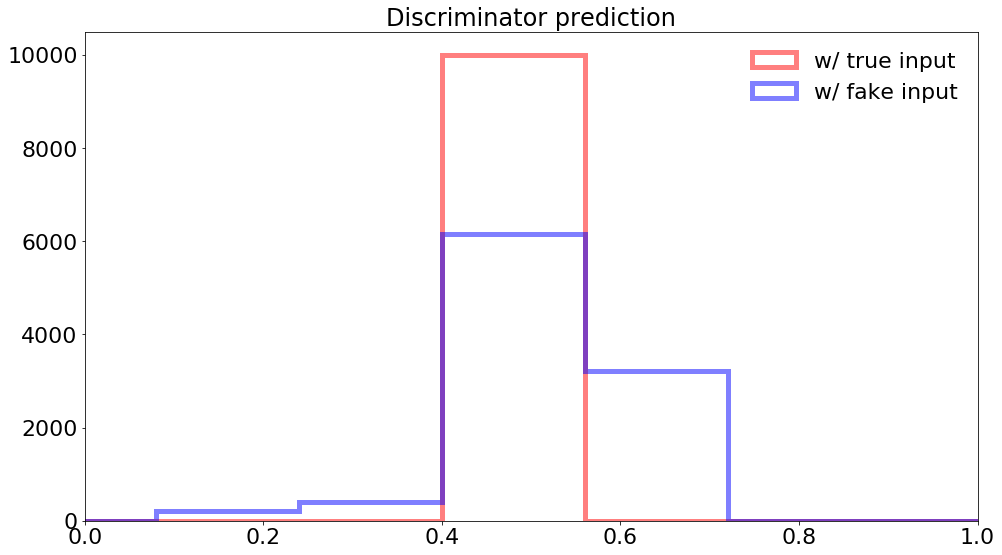

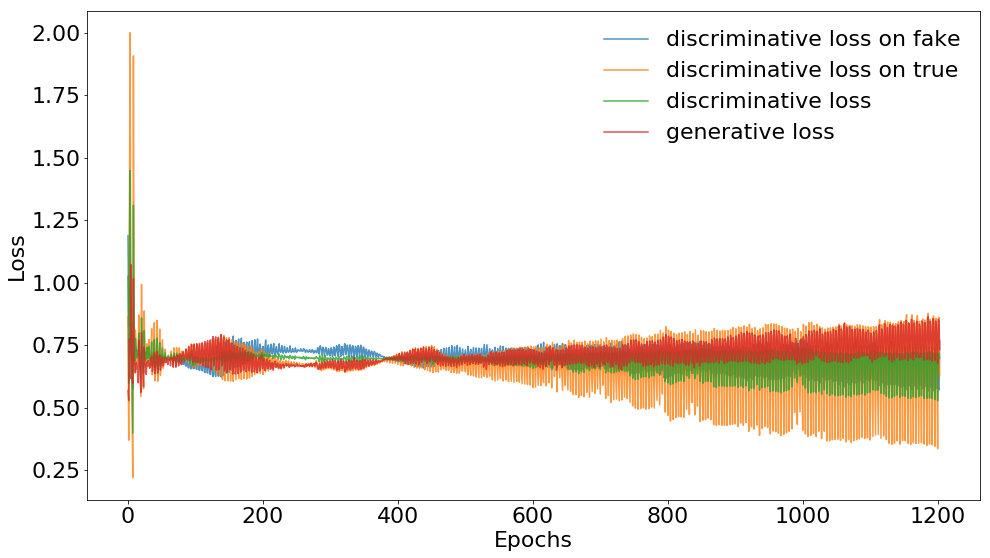

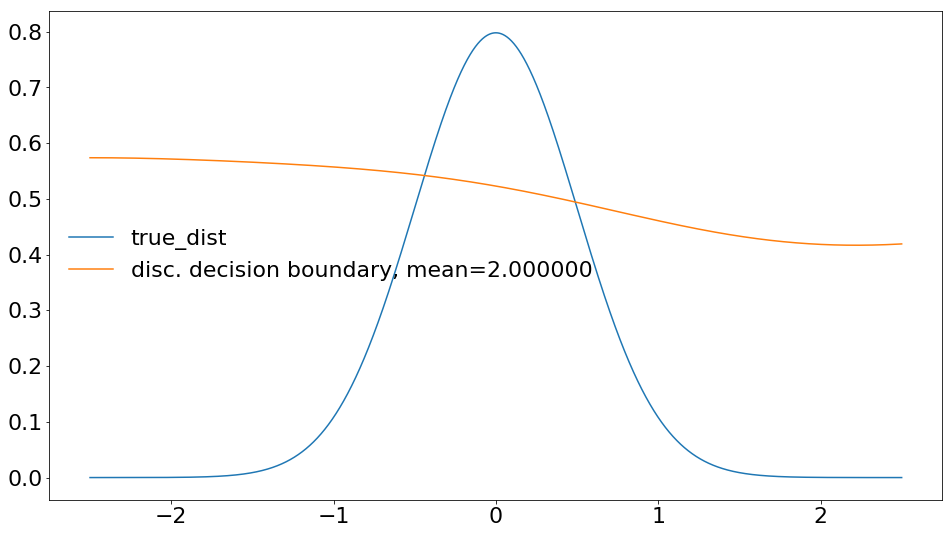

In [ ]:
pretrain_disc = False
if pretrain_disc ==True:
    #temp (pretrain dicriminator)
    true_disc_x = gaussian(batch_size,mu=0.,sigma=0.5)
    mean_col = mean*np.ones((batch_size,1))
    latent = noise_g(batch_size, mu=0, sigma=10.)
    true_disc_y = np.zeros(batch_size)
    fake_disc_x = G.predict([latent, mean_col])
    fake_disc_y = np.ones(batch_size)
    

    #x_disc = np.concatenate((true_disc_x, fake_disc_x))
    #x_disc = x_disc.reshape((x_disc.shape[0], 1))
    #y_disc = np.concatenate((true_disc_y, fake_disc_y))

    G.trainable = False
    D.trainable = True
    #d_loss_true = D.train_on_batch(true_disc_x, true_disc_y)
    #d_loss_fake = D.train_on_batch(fake_disc_x, fake_disc_y)
    d_loss = D.train_on_batch([true_disc_x, mean_col], true_disc_y)
    d_loss = D.train_on_batch([fake_disc_x, mean_col], fake_disc_y)

    print d_loss


nb_epochs = 25001
mean_arr = [-2, -0.5, 0.5, 2.]

for i in range(0,nb_epochs):
    mc=0
    for m_true in mean_arr:
        d_loss, g_loss = train(G,D,Model,i,m_true)
        #losses["d"].append(d_loss)
        #losses["g"].append(g_loss)  

        if i % 100 == 0:
            print("Epoch {0}, Discriminator loss:{1}, GAN loss:{2}".format(i + 1, d_loss, g_loss))
            #overlay GAN output on the Gaussian we want

            true_disc = gaussian(10000,mu=m_true,sigma=0.5)
            sd = np.std(true_disc)
            mean = np.mean(true_disc)
            print "For true: mean and s.d. = ", mean, sd
            mean_col = m_true*np.ones((10000,1))
            latent = noise_g(10000,mu=0.,sigma=10.)*mean_col

            G.trainable = False
            D.trainable = False
            fake_disc = G.predict([latent, mean_col])

            sd = np.std(fake_disc)
            mean = np.mean(fake_disc)
            print "For generator: mean and s.d. = ", mean, sd

            plt.figure(figsize=(16,9))
            plt.title("True (mu=0, sigma=0.5) vs. Generator Output", fontsize=24)
            plt.hist(latent, color='r', histtype='step', linewidth=5, bins = 50, range = (-10,10), label = "Noise", alpha=0.5)
            plt.hist(true_disc, color='g', histtype='step', linewidth=5, bins = 50, range = (-10,10), label = "True", alpha=0.5)
            plt.hist(fake_disc, color='b', histtype='step', linewidth=5, bins = 50, range = (-10,10), label = 'Fake/Generator', alpha=0.5)
            plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
            # plt.ylim(0,0.6)
            plt.rc('xtick', labelsize = 22)
            plt.rc('ytick', labelsize = 22)
            plt.show()     
            #print losses

            true_pred = D.predict([true_disc,mean_col])
            fake_pred = D.predict([fake_disc,mean_col])

            plt.figure(figsize=(16,9))
            plt.title("Discriminator prediction", fontsize=24)
            plt.hist(true_pred, color='r', histtype='step', linewidth=5, bins = 25, range = (-2.,2.), label = "w/ true input", alpha=0.5)
            plt.hist(fake_pred, color='b', histtype='step', linewidth=5, bins = 25, range = (-2.,2.), label = 'w/ fake input', alpha=0.5)
            plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
            plt.xlim(0.,1.)
            plt.rc('xtick', labelsize = 22)
            plt.rc('ytick', labelsize = 22)
            plt.show()


            plot_loss(losses)
            plot_decision_boundary(D, m_true)
    #savemodel(model=G, name="Gen_mbd_varg_%d"%mc)
    #mc=mc+1

(array([  4.00000000e+00,   2.10000000e+01,   1.74000000e+02,
          5.84000000e+02,   1.87600000e+03,   5.11000000e+03,
          1.07750000e+04,   1.92920000e+04,   2.82900000e+04,
          3.38740000e+04]),
 array([ -1.18561125e+00,  -1.06705022e+00,  -9.48489184e-01,
         -8.29928152e-01,  -7.11367120e-01,  -5.92806088e-01,
         -4.74245057e-01,  -3.55684025e-01,  -2.37122993e-01,
         -1.18561961e-01,  -9.28892518e-07]),
 <a list of 10 Patch objects>)

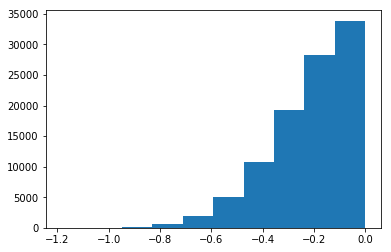

In [38]:
p = G.predict([noise_g(batch_size=100000, mu=-3., sigma=3.), 2.9*np.ones((100000,1))])
plt.hist(p)

In [ ]:
sd = np.std(p, dtype=np.float64)
v = np.var(p, dtype=np.float64)
mean = np.mean(p, dtype=np.float64)
from keras.layers import Activation, Dense
print mean, sd
savemodel(model=G, name="Gen_mbd_varg")
#save_model(model=D, filepath="/home/kaustuv1993/Desktop/H2bb/Models_and_Weights/Disc_mbd_1")

#savemodel(model=Model, name="GaussiGAN_mbd_1")

-0.273640057625 4.43121941418
For generator: mean and s.d =  -0.730299 0.552473


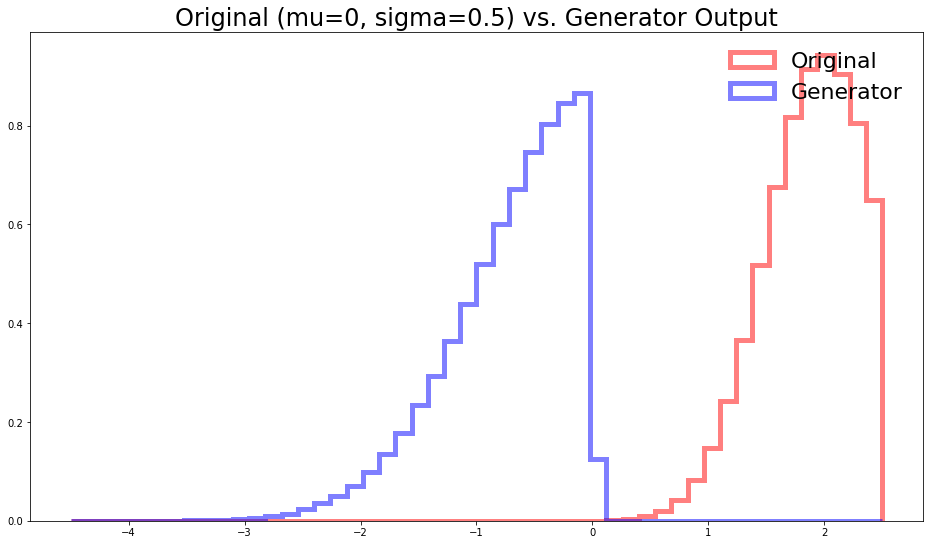

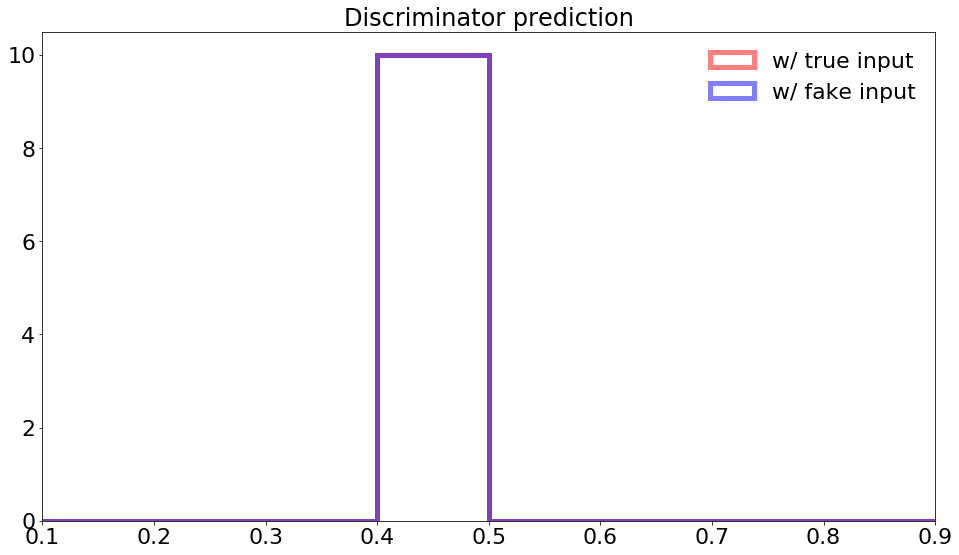

In [39]:
        ###################
        batch_size = 1000000    
        true_disc = gaussian(batch_size,mu=2.,sigma=0.5)
        true_disc.sort()
        print true_disc.min(), true_disc.max()
        sd = np.std(true_disc)
        mean = 2
        mean_col = mean*np.ones((batch_size,1))
        latent = noise_g(batch_size,mu=0.,sigma=10.)
        G.trainable = False
        D.trainable = False
        fake_disc = G.predict([latent, mean_col])
        latent.sort()
        G.trainable = False
        D.trainable = False
        fake_disc = G.predict([latent,mean_col])
        #print fake_disc
        sd = np.std(fake_disc)
        mean = np.mean(fake_disc)
        print "For generator: mean and s.d = ", mean, sd
        ###################
        
        plt.figure(figsize=(16,9))
        plt.title("Original (mu=0, sigma=0.5) vs. Generator Output", fontsize=24)
        plt.hist(true_disc, color='r', histtype='step', linewidth=5, bins = 50, range = (-4.5,2.5), label = "Original", alpha=0.5, normed=True)
        plt.hist(fake_disc, color='b', histtype='step', linewidth=5, bins = 50, range = (-4.5,2.5), label = 'Generator', alpha=0.5, normed=True)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        # plt.ylim(0,0.6)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        #plt.savefig("GaussiGAN_mbd_unilat_gen_PDF.png")
        plt.show()     
        #print losses
        
        true_pred = D.predict([true_disc, mean_col])
        fake_pred = D.predict([fake_disc, mean_col])
            
        plt.figure(figsize=(16,9))
        plt.title("Discriminator prediction", fontsize=24)
        plt.hist(true_pred, color='r', histtype='step', linewidth=5, bins = 10, range = (0.,1.), label = "w/ true input", alpha=0.5, normed=True)
        plt.hist(fake_pred, color='b', histtype='step', linewidth=5, bins = 10, range = (0.,1.), label = 'w/ fake input', alpha=0.5, normed=True)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        plt.xlim(0.1,0.9)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        #plt.savefig("GaussiGAN_mbd_unilat_disc_pred.png")
        plt.show()

In [ ]:
batch_size=1000000
import scipy.stats as stats        

true = gaussian(batch_size=batch_size, mu=0., sigma = 0.5)
true.sort()
tmean = np.mean(true)
tstd = np.std(true)
tpdf = stats.norm.pdf(true, tmean, tstd)
tcdf = stats.norm.cdf(true, tmean, tstd)
#x = np.linspace(true.min(), true.max(), 100000)

latent = noise_g(batch_size=batch_size, mu=0., sigma = 1.0)
latent.sort()
G_x = G.predict(latent)

H_G,X_G = np.histogram(G_x, bins = 100, normed = True )
dx = X_G[1] - X_G[0]
F_G[1:] = np.cumsum(H_G)*dx




plt.figure(figsize=(16,9))
plt.title("CDF/PDF overlay", fontsize=24)

plt.plot(true, tpdf, 
         color='b', linestyle='--', linewidth=5, label = r"$\mathrm{True\ PDF\ (\mu=0,\ \sigma=0.5)}$")

plt.plot(true, tcdf, 
         color = 'k', linestyle='--', linewidth=5, label = "True CDF")

plt.hist(G_x, histtype='step', bins =100, normed=True,
         color = 'r', linewidth=3, label ="Generator PDF")

plt.plot(X_G, F_G, 
         color = 'y', linewidth=3, label="Generator CDF")

plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
plt.rc('xtick', labelsize = 22)
plt.rc('ytick', labelsize = 22)
plt.savefig("GaussiGAN_1_mbd_g1_overlay.png")
plt.show()


In [ ]:
print F_G.shape, X_G.shape

In [ ]:
        from scipy.stats import norm
        batch_size=100000
        
        
        g_inp = noise_g(batch_size=100000, mu=0., sigma = 1.0)
        x = np.linspace(g_inp.min(),g_inp.max(), 100000)
        x.sort()
        g_inp.sort()
        dx = ((x.max()-x.min())/100000.)
        G_x = G.predict(g_inp)
        
        
        plt.figure(figsize=(16,9))
        plt.title("CDF/PDF overlay", fontsize=24)
        plt.hist(G_x, color='chartreuse', bins=50,  linewidth=3,label = "Generator predictions", normed = True, alpha=0.5)
        #G_x /= (dx*G_x).sum()
        #CDF_gen = np.cumsum(G_x*dx)
        plt.plot(g_inp, G_x, color = 'burlywood', linewidth=3, label ="Generator CDF")
        plt.plot(x, norm.pdf(x, loc = 0., scale = 0.5), color='c', linewidth=3, label = "True PDF")
        plt.plot(x, norm.cdf(x, loc = 0., scale = 0.5), color = 'm', linewidth=3, label="True CDF")
        plt.plot(x, norm.ppf(x, loc = 0., scale = 0.5), color = 'y', linewidth=3, label="True PPF")
        plt.plot(g_inp, norm.pdf(G_x, loc = 0., scale = 0.5), color = 'r', linestyle = '--', linewidth=3, label="Gen. PDF")
        plt.plot(g_inp, norm.cdf(G_x, loc = 0., scale = 0.5), color = 'g', linestyle = '--', linewidth=3, label="Gen. CDF")
        plt.plot(g_inp, norm.ppf(G_x, loc = 0., scale = 0.5), color = 'b', linestyle = '--', linewidth=3, label="Gen. PPF")
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        #plt.ylim(-2,2)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        plt.savefig("GaussiGAN_1_mbd_g1_overlay.png")
        plt.show()
        

In [ ]:
2+2

In [36]:
from keras.utils import plot_model
plot_model(Model, show_shapes=True, to_file='/home/kaustuv1993/Desktop/VarGaussiGAN.png')